$Name:$ $Mukaila$ $Rafiu$

$Program:$ $Master's$ $in$ $Economics$ $and$ $Data$ $Science$

$Course:$ $Financial$ $Economics$

$School:$ $Northeastern University$ - $Seattle.$

Project Title: Intangible Capital and the Stability of the Investment–q Relation in U.S. Tech Firms Since 1995

Project Question: Does replacing standard Tobin's q with a total-q measure that incorporates internally generated intangible capital restore a stable relation between physical investment and q for public U.S. tech firms from 1995 onward?

The questions to be answered:
    
Focus exclusively on public U.S. tech firms only.
    
Focus on post-1995 as a structural break.
    
• Study on the subperiod stability over time of the physical investment–q relation.
    
• Breaking heterogeneity among R&D-intensive tech firms.
    
• Framing the question as “restoring stability.

In [1]:
#1 Imports & Setup
import pandas as pd
import numpy as np
import os
import wrds
import matplotlib.pyplot as plt
from datetime import datetime
from plotnine import *
import pyfixest as pf
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [2]:
#2 WRDS data Download
conn = wrds.Connection()

Enter your WRDS username [gon_c]: rafium
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\gon_c\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [33]:
#3. Fetching Compustat data from the WRDS database api (Physical Capital & Investment)
comp_query = f"""SELECT gvkey, fyear, datadate, at, ppegt, capx, xsga, xrd, sale, ceq, lt, dltt, dlc, prcc_f, csho
FROM comp.funda
WHERE indfmt='INDL' AND datafmt='STD' AND consol='C' AND curcd='USD'
AND fyear BETWEEN {1995} AND {2024}
"""
compustat = conn.raw_sql(comp_query)
compustat.round(3)

,gvkey,fyear,datadate,at,ppegt,capx,xsga,xrd,sale,ceq,lt,dltt,dlc,prcc_f,csho
0,001004,1995,1996-05-31,437.846,129.49,7.547,58.323,<NA>,504.99,204.635,233.211,118.292,1.474,22.125,15.998
1,001010,1995,1995-12-31,2015.8,1502.5,109.3,43.4,1.1,407.2,473.2,1536.2,710.5,316.2,<NA>,0.015
2,001013,1995,1995-10-31,601.083,191.537,32.456,196.757,66.46,586.222,510.866,90.217,0.0,0.41,40.0,62.737
3,001019,1995,1995-12-31,28.487,41.034,1.946,8.202,<NA>,27.492,13.528,14.959,2.014,0.222,115.0,0.198
4,001021,1995,1995-06-30,11.79,6.011,0.131,7.637,0.751,26.589,4.26,6.252,2.736,0.644,0.875,6.449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298501,355398,2024,2024-12-31,684.425,567.079,34.742,79.644,0.0,778.308,360.028,322.764,171.219,41.407,28.76,65.03
298502,356128,2024,2024-12-31,15967.927,537.105,182.467,517.64,208.823,4826.644,2892.041,12969.834,0.263,262.67,94.71,190.016
298503,356859,2024,2024-12-31,2207.739,241.14,27.575,225.99,<NA>,1097.393,1151.172,1056.567,787.801,24.778,12.75,122.476
298504,366911,2024,2024-12-31,23805.0,16630.0,642.0,862.0,<NA>,11704.0,9915.0,13891.0,9196.0,348.0,<NA>,<NA>


In [34]:
#4 Fetching Peters–Taylor Total q and Intangible Capital from WRDS data base api
pt_query = f"""
SELECT gvkey, fyear, q_tot, k_int, k_int_know, k_int_org
FROM totalq.total_q
WHERE fyear BETWEEN {1995} AND {2024}
"""
pt = conn.raw_sql(pt_query)
pt.round(3)

,gvkey,fyear,q_tot,k_int,k_int_know,k_int_org
0,001004,1995.0,0.615,91.113,0.0,85.271
1,001004,1996.0,1.183,95.568,0.0,89.915
2,001004,1997.0,1.572,125.286,0.0,98.72
3,001004,1998.0,0.642,149.054,0.0,108.962
4,001004,1999.0,0.189,158.58,0.0,119.74
...,...,...,...,...,...,...
271685,353945,2021.0,<NA>,216.882,124.15,81.986
271686,353945,2022.0,1.995,291.299,165.048,115.711
271687,353945,2023.0,2.384,440.401,203.53,154.131
271688,356128,2022.0,5.723,485.413,319.62,132.708


In [35]:
#5 Industry Classification (Tech Firms)
sic_query = "SELECT DISTINCT gvkey, sic FROM comp.company"
sic = conn.raw_sql(sic_query)
sic.round(3)

,gvkey,sic
0,296885,2836
1,122138,3576
2,065194,3825
3,062927,6035
4,037826,8082
...,...,...
56725,133564,3827
56726,166583,3827
56727,013252,1040
56728,051007,6722


In [36]:
#6 Saving the Raw Dataos.makedirs("data_raw", exist_ok=True)
compustat.to_csv("data_raw/comp_funda.csv", index=False)
pt.to_csv("data_raw/peters_taylor_totalq.csv", index=False)
sic.to_csv("data_raw/sic_codes.csv", index=False)

In [37]:
#7 Merging and Constructing Panel
compustat = pd.read_csv("data_raw/comp_funda.csv")
pt = pd.read_csv("data_raw/peters_taylor_totalq.csv")
sic = pd.read_csv("data_raw/sic_codes.csv")
panel = (compustat.merge(sic, on="gvkey", how="left").merge(pt, on=["gvkey", "fyear"], how="left"))
panel.round(3)

,gvkey,fyear,datadate,at,ppegt,capx,xsga,xrd,sale,ceq,lt,dltt,dlc,prcc_f,csho,sic,q_tot,k_int,k_int_know,k_int_org
0,1004,1995,1996-05-31,437.846,129.490,7.547,58.323,NaN,504.990,204.635,233.211,118.292,1.474,22.125,15.998,5080.0,0.615,91.113,0.000,85.271
1,1010,1995,1995-12-31,2015.800,1502.500,109.300,43.400,1.100,407.200,473.200,1536.200,710.500,316.200,NaN,0.015,3743.0,NaN,82.734,16.801,65.933
2,1013,1995,1995-10-31,601.083,191.537,32.456,196.757,66.460,586.222,510.866,90.217,0.000,0.410,40.000,62.737,3661.0,4.177,302.152,168.979,133.173
3,1019,1995,1995-12-31,28.487,41.034,1.946,8.202,NaN,27.492,13.528,14.959,2.014,0.222,115.000,0.198,7380.0,0.262,14.596,0.167,10.761
4,1021,1995,1995-06-30,11.790,6.011,0.131,7.637,0.751,26.589,4.260,6.252,2.736,0.644,0.875,6.449,3844.0,-0.044,21.230,8.119,12.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298501,355398,2024,2024-12-31,684.425,567.079,34.742,79.644,0.000,778.308,360.028,322.764,171.219,41.407,28.760,65.030,5812.0,NaN,NaN,NaN,NaN
298502,356128,2024,2024-12-31,15967.927,537.105,182.467,517.640,208.823,4826.644,2892.041,12969.834,0.263,262.670,94.710,190.016,6141.0,NaN,NaN,NaN,NaN
298503,356859,2024,2024-12-31,2207.739,241.140,27.575,225.990,NaN,1097.393,1151.172,1056.567,787.801,24.778,12.750,122.476,8734.0,NaN,NaN,NaN,NaN
298504,366911,2024,2024-12-31,23805.000,16630.000,642.000,862.000,NaN,11704.000,9915.000,13891.000,9196.000,348.000,NaN,NaN,3241.0,NaN,NaN,NaN,NaN


In [38]:
#8 Converting all variables from wide to long format for easy filtering and plotting
all_variables = panel.melt(id_vars=['gvkey', 'fyear', 'datadate'],
value_vars=['at', 'ppegt', 'capx', 'xsga', 'xrd', 'sale', 'ceq', 'lt', 'dltt', 'dlc', 'prcc_f', 'csho', 'sic',
'q_tot', 'k_int', 'k_int_know', 'k_int_org'],
var_name='variable', value_name='value')

In [39]:
#9 Checking the Company 1004
print("First few gvkeys in data:")
print(panel['gvkey'].unique()[:10])

First few gvkeys in data:
[1004 1010 1013 1019 1021 1025 1034 1036 1037 1038]


In [40]:
#10 Converting datadate to datetime
all_variables['datadate'] = pd.to_datetime(all_variables['datadate'])

In [41]:
#11 Plot all variables for gvkey 1004
company_1004 = all_variables.query('gvkey == 1004').dropna()
print(f"Variables available for gvkey 1004:")
print(company_1004['variable'].unique())
print(f"\nNumber of observations: {len(company_1004)}")

Variables available for gvkey 1004:
['at' 'ppegt' 'capx' 'xsga' 'sale' 'ceq' 'lt' 'dltt' 'dlc' 'prcc_f' 'csho'
 'sic' 'q_tot' 'k_int' 'k_int_know' 'k_int_org']

Number of observations: 476


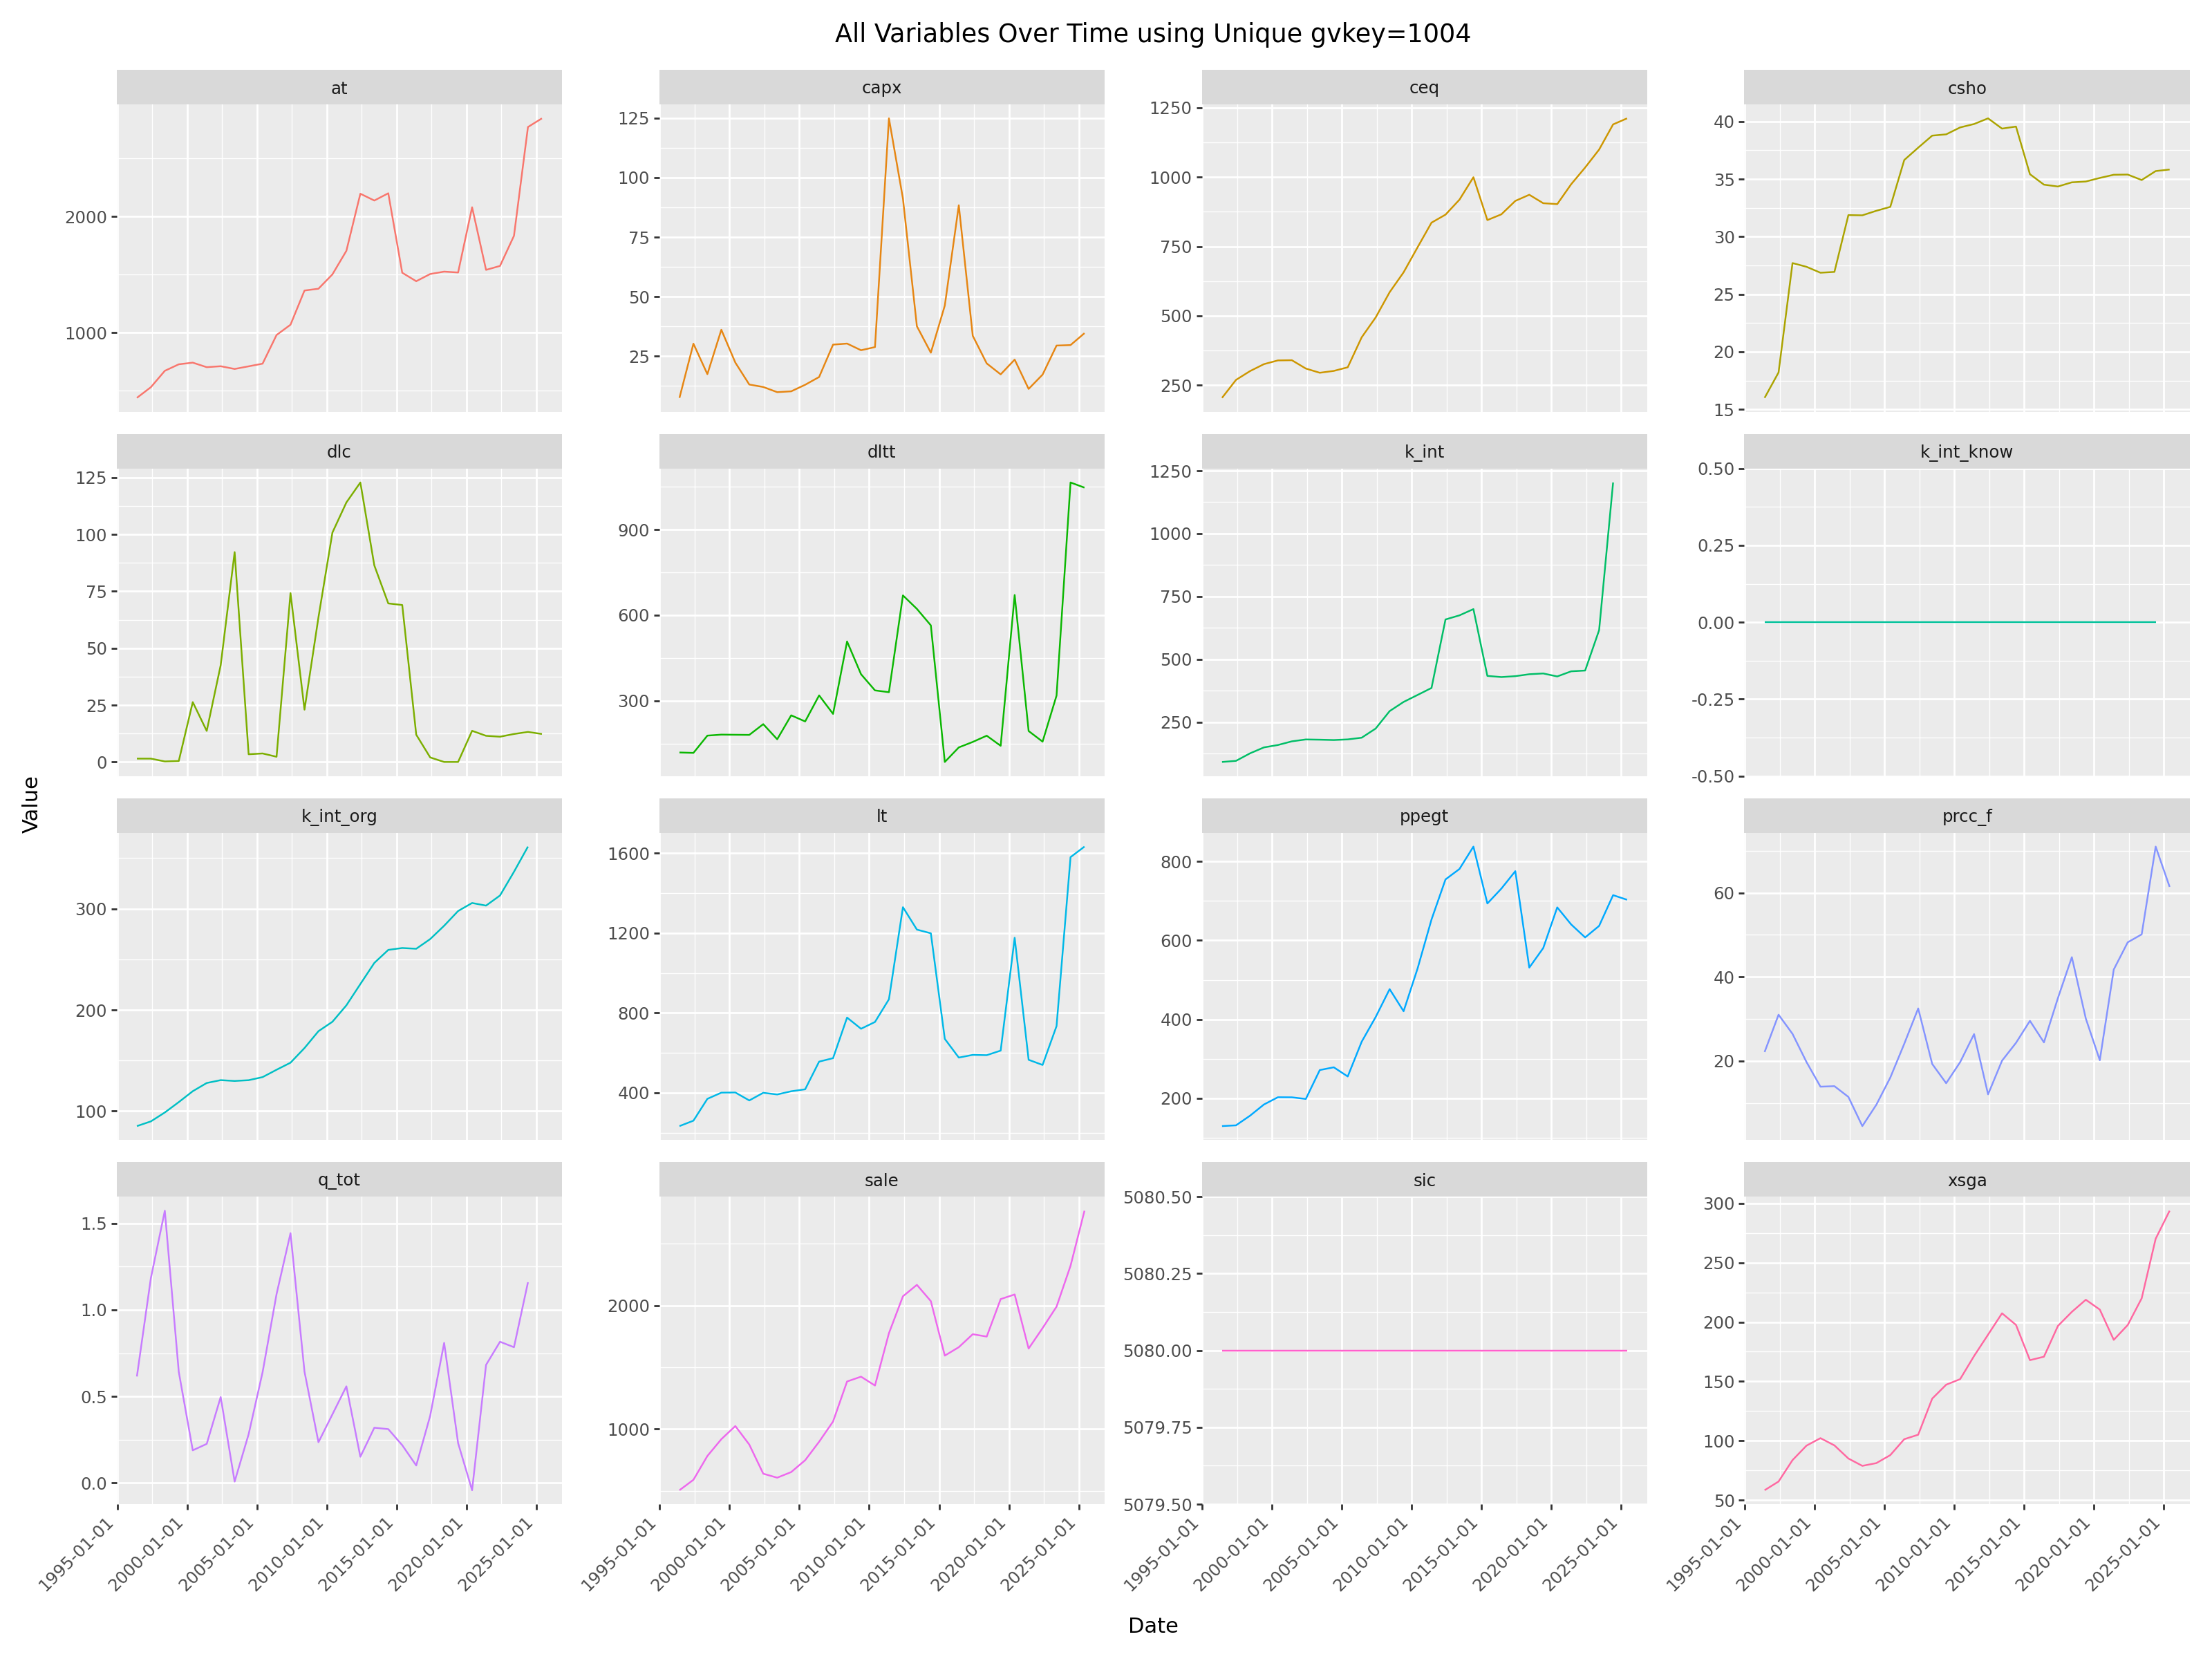

In [42]:
#12 Creating plots with all the variables using company 1004 as the leading company (Unique)
(ggplot(company_1004)
+ aes(x='datadate', y='value', color='variable')
+ geom_line()
+ facet_wrap('~variable', scales='free_y', ncol=4) # 4 columns
+ labs(x='Date', y='Value', title='All Variables Over Time using Unique gvkey=1004')
+ theme(legend_position='none', figure_size=(16, 12), axis_text_x=element_text(rotation=45, hjust=1)))

In [43]:
#13. Tech companies on SICpanel["sic"] = panel["sic"].astype("Int64")
panel["is_tech"] = (
((panel["sic"] >= 3570) & (panel["sic"] <= 3579)) | # Computer equipment
((panel["sic"] >= 3650) & (panel["sic"] <= 3699)) | # Electronics
((panel["sic"] >= 7370) & (panel["sic"] <= 7379)) # Software
)
panel = panel[panel["is_tech"]]
#Following the literature (Peters and Taylor, 2017),
#We define technology firms as those with SIC codes in the following ranges:
#1. 3570-3579 (computer equipment).
#2. 3650-3699 (electronics and electrical equipment).
#3. 7370-7379 (software and computer services).

In [44]:
#14 Construct Tobin’s q Measures
#(Standard q)
panel["mkt_equity"] = panel["prcc_f"] * panel["csho"]
panel["total_debt"] = panel["dltt"].fillna(0) + panel["dlc"].fillna(0)
panel["mkt_value_assets"] = panel["mkt_equity"] + panel["total_debt"]
panel["Standard_q"] = panel["mkt_value_assets"] / panel["at"]
panel = panel[(panel["Standard_q"] > 0) & (panel["Standard_q"] < 50)]

In [45]:
#15 Total q
panel["Total_q"] = panel["q_tot"]

In [46]:
#16 Investment, Capital, and Cash Flow
panel = panel[(panel["at"] > 0) & (panel["ppegt"] > 0)]
panel = panel.sort_values(["gvkey", "fyear"])
panel["inv_phys"] = panel["capx"]
panel["k_phys"] = panel["ppegt"]
panel["i_over_k"] = panel["inv_phys"] / panel["k_phys"]
panel["Investment_lead"] = panel.groupby("gvkey")["i_over_k"].shift(-1)
panel["Cash_flows"] = (panel["xrd"].fillna(0) + panel["xsga"].fillna(0)) / panel["at"]

In [47]:
#17. Intangible Intensity
panel["K_tang"] = panel["at"] - panel["k_int"].fillna(0)
panel["intensity_int"] = panel["k_int"] / (panel["k_int"] + panel["K_tang"])
panel = panel[panel["intensity_int"].between(0, 1)]

In [48]:
# #18 Trimming and Winsorization
panel = panel[panel["i_over_k"].between(-2, 2)]
panel = panel[panel["Investment_lead"].between(-2, 2)]

# Winsorization function
def winsorize(x, p=0.01):
    lo, hi = x.quantile(p), x.quantile(1 - p)
    return x.clip(lo, hi)

# Apply winsorization
for col in ["inv_phys", "k_phys", "i_over_k", "Investment_lead", "Total_q", "Standard_q", "Cash_flows", "intensity_int"]:
    panel[col] = winsorize(panel[col])


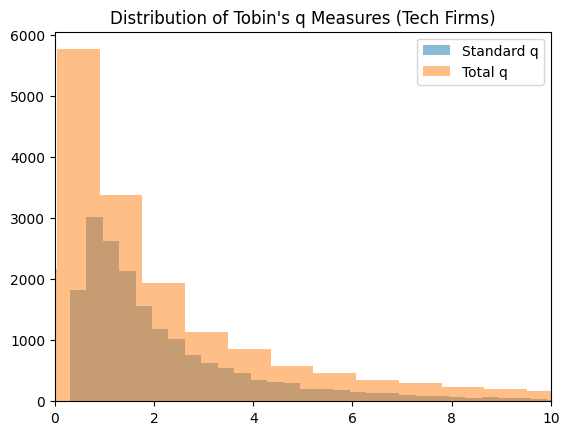

In [49]:
#19 Distribution of Standard q vs Total q in (High Value, Low Effort) 
plt.hist(panel["Standard_q"], bins=50, alpha=0.5, label="Standard q")
plt.hist(panel["Total_q"], bins=50, alpha=0.5, label="Total q")
plt.xlim(0, 10)
plt.legend()
plt.title("Distribution of Tobin's q Measures (Tech Firms)")
plt.show()

In [50]:
#20 summary statistics, including Tobin’s Q
vars_for_table = {"inv_phys": "Capital expenditures",
"k_phys": "Gross PP&E",
"i_over_k": "Investment rate",
"Investment_lead": "Lead investment rate",
"Standard_q": "Tobin's q",
"Total_q": "Total q",
"Cash_flows": "Cash flow",
"intensity_int": "Intangible intensity",}
sub = panel[list(vars_for_table.keys())].copy()
summary = sub.agg(["mean", "median", "std"]).T
summary.index = [vars_for_table[v] for v in summary.index]
summary.columns = ["Mean", "Median", "Std. dev."]
print(summary.round(3).to_markdown())

|                      |    Mean |   Median |   Std. dev. |
|:---------------------|--------:|---------:|------------:|
| Capital expenditures | 108.012 |    6.63  |     374.485 |
| Gross PP&E           | 971.59  |   42.961 |    3583.88  |
| Investment rate      |   0.188 |    0.136 |       0.165 |
| Lead investment rate |   0.164 |    0.122 |       0.141 |
| Tobin's q            |   2.565 |    1.602 |       2.785 |
| Total q              |   3.337 |    1.223 |       6.375 |
| Cash flow            |   0.348 |    0.313 |       0.219 |
| Intangible intensity |   0.548 |    0.556 |       0.256 |


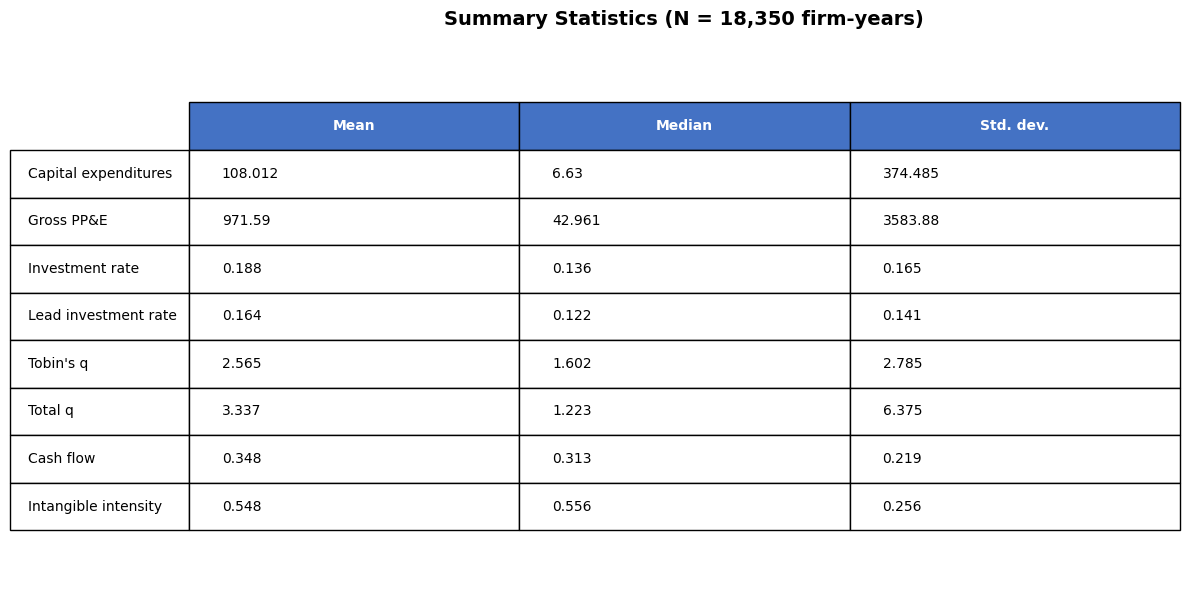

In [52]:
#21 Summary Statistics Visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

table = ax.table(cellText=summary.round(3).values, colLabels=summary.columns, rowLabels=summary.index, loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Color header
for i in range(len(summary.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Summary Statistics (N = 18,350 firm-years)', fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()

From the summary statistics, Capital expenditures reports a mean of 108 and a median of only 6.6, while gross PP&E
has a mean of 972 and a median of 43. This large gap between means and medians. It indicates a highly
right-skewed distribution. This reflects the presence of a small number of very large firms alongside many smaller
ones, a typical charatcteristics of the U.S. tech sector.
The Investment rate reports a mean of 0.188 while lead investment rate reports a mean of 0.164, together with
sizable standard deviations of (0.165 and 0.141). This indicate substantial time-series and cross-sectional variation
in physical investment suggesting that tech firms invest heavily relative to their capital stock, but that investment is
volatile and uneven over time, consistent with lumpy adjustment and R&D-driven investment dynamics.
Moreover, Standard q (Tobin’s q) has a mean of 2.57 and a standard deviation of 2.79, when Total q is higher on
average at 3.34 and significantly dispersed, with a standard deviation of 6.38. This greater dispersion is consistent
with the idea that incorporating intangible capital introduces additional volatility into valuations, reflecting innovation,
learning, and jump risk (as emphasized by Peters and Taylor, 2017; Andrei, Mann, and Moyen, 2018).
Intangible intensity has a mean of 0.55, indicating that, on average, more than half of firms’ total capital consists of
intangible assets. This confirms that the U.S. tech sector is predominantly intangible-capital-intensive and supports
the view that ignoring intangibles makes standard Tobin’s q a noisy proxy for true investment opportunities.

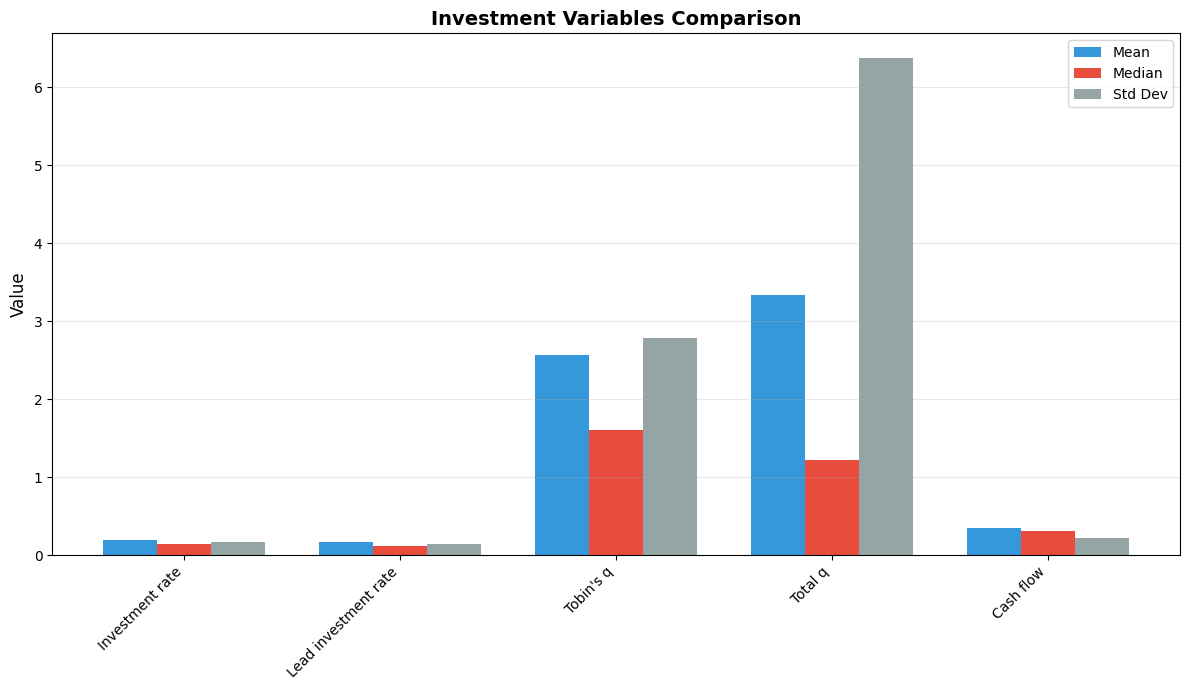

In [53]:
#22 Investment-related variables
summary_reset = summary.reset_index().rename(columns={'index': 'Variable'})
investment_vars = ["Investment rate", "Lead investment rate", 
                   "Tobin's q", "Total q", "Cash flow"]
inv_data = summary_reset[summary_reset['Variable'].isin(investment_vars)]

plt.figure(figsize=(12, 7))
x = range(len(inv_data))
width = 0.25

plt.bar([i-width for i in x], inv_data['Mean'], width, label='Mean', color='#3498db')
plt.bar([i for i in x], inv_data['Median'], width, label='Median', color='#e74c3c')
plt.bar([i+width for i in x], inv_data['Std. dev.'], width, label='Std Dev', color='#95a5a6')

plt.xticks(x, inv_data['Variable'], rotation=45, ha='right')
plt.ylabel('Value', fontsize=12)
plt.title('Investment Variables Comparison', fontsize=14, weight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

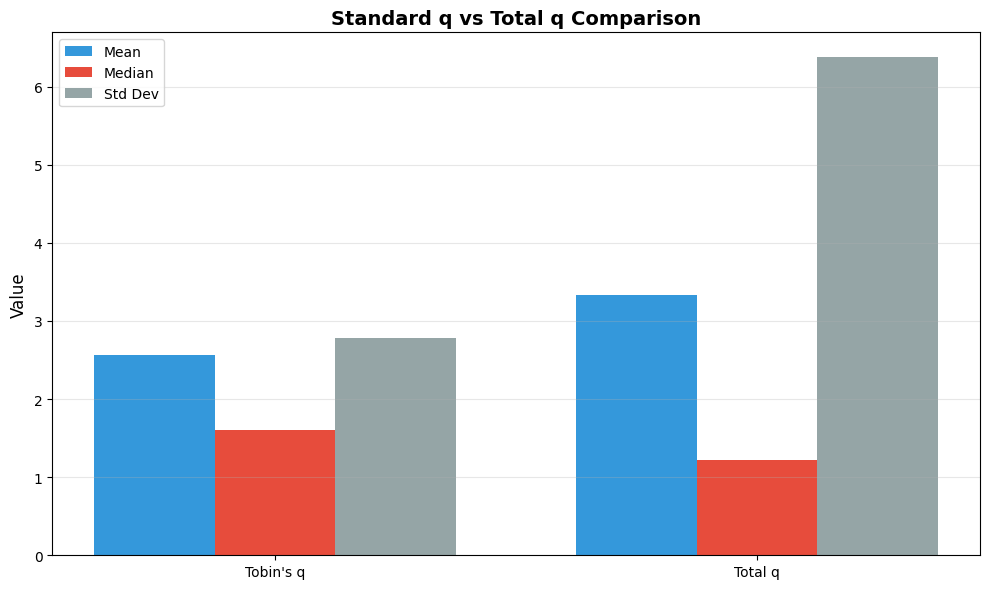

In [54]:
#23 Q Comparison (Standard q vs Total q)
q_data = summary_reset[summary_reset['Variable'].isin(["Tobin's q", 'Total q'])]
x = range(len(q_data))
width = 0.25
plt.figure(figsize=(10, 6))
plt.bar([i-width for i in x], q_data['Mean'], width, label='Mean', color='#3498db')
plt.bar([i for i in x], q_data['Median'], width, label='Median', color='#e74c3c')
plt.bar([i+width for i in x], q_data['Std. dev.'], width, label='Std Dev', color='#95a5a6')
plt.xticks(x, q_data['Variable'])
plt.ylabel('Value', fontsize=12)
plt.title("Standard q vs Total q Comparison", fontsize=14, weight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
#24 Preparation for running pyfixest regression for investment lead

#Contruction of standardized q measures purposely for comparison
panel["Standardized_q"] = (panel["Standard_q"] - panel["Standard_q"].mean()) / panel["Standard_q"].std()
panel["Totalized_q"] = (panel["Total_q"] - panel["Total_q"].mean()) / panel["Total_q"].std()

panel["gvkey"] = panel["gvkey"].astype(str)
panel = panel.rename(columns={"fyear": "year"})
panel = panel.dropna(subset=["Investment_lead", "Cash_flows", "Standard_q", "Total_q", "Standardized_q", "Totalized_q",])

# Require at least 2 obs per firm and year
counts_firm = panel.groupby("gvkey")["year"].transform("count")
counts_year = panel.groupby("year")["gvkey"].transform("count")
panel = panel[(counts_firm >= 2) & (counts_year >= 2)]

In [61]:
#25 Standard q (Tobins) Regressions Analysis

df = panel
#Model 1: Baseline
M1 = pf.feols("Investment_lead ~ Cash_flows + Standard_q", data=df)
#Model 2 with Firm Effect 
M2 = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey", data=df)
#Model 3 with Firm and Year Effect 
M3 = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df)
#Model 3 with Firm, Year and Cluster Effect
M4 = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df)
#Model 5 with Standardized Effect for Comparison 
M5 = pf.feols("Investment_lead ~ Cash_flows + Standardized_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df)

In [57]:
#26 Total q (Peters–Taylor)  Regressions Analysis
#Model 6: Baseline
M6 = pf.feols("Investment_lead ~ Cash_flows + Total_q", data=df)
#Model 7 with Firm Effect 
M7 = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey", data=df)
#Model 8 with Firm and Year Effect 
M8 = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df)
#Model 9 with Firm, Year and Cluster Effect
M9 = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df)
#Model 10 with Totalized_q Effect for Comparison 
M10 = pf.feols("Investment_lead ~ Cash_flows + Totalized_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df)

In [58]:
#27 BaseLine Results of the Model For Standard q (Tobins q) and Total q
baseline_models = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]
pf.etable(baseline_models)

GT(_tbl_data=   level_0               level_1                      0  \
0     coef            Cash_flows    -0.003 <br> (0.005)   
1     coef            Standard_q  0.019*** <br> (0.000)   
2     coef        Standardized_q                          
3     coef               Total_q                          
4     coef           Totalized_q                          
5     coef             Intercept  0.113*** <br> (0.002)   
6       fe                 gvkey                      -   
7       fe                  year                      -   
8    stats          Observations                  18350   
9    stats             S.E. type                    iid   
10   stats         R<sup>2</sup>                  0.145   
11   stats  R<sup>2</sup> Within                      -   

                         1                       2                       3  \
0   -0.093*** <br> (0.007)  -0.119*** <br> (0.006)  -0.119*** <br> (0.010)   
1    0.020*** <br> (0.000)   0.017*** <br> (0.000)   0.017*** <br> (0.001)   
2                                                                            
3                                                                            
4                                                                            
5                                                                            
6                        x                       x                       x   
7                        -                       x                       x   
8                    18350                   18350                   18350   
9                      iid                     iid               by: gvkey   
10                   0.494                   0.549                   0.549   
11                   0.151                   0.112                   0.112   

                         4                      5                       6  \
0   -0.119*** <br> (0.010)  0.042*** <br> (0.004)  -0.036*** <br> (0.007)   
1                                                                           
2    0.046*** <br> (0.002)                                                  
3                           0.010*** <br> (0.000)   0.010*** <br> (0.000)   
4                                                                           
5                           0.114*** <br> (0.002)                           
6                        x                      -                       x   
7                        x                      -                       -   
8                    18350                  18350                   18350   
9                by: gvkey                    iid                     iid   
10                   0.549                  0.202                   0.516   
11                   0.112                      -                   0.188   

                         7                       8                       9  
0   -0.069*** <br> (0.006)  -0.069*** <br> (0.010)  -0.069*** <br> (0.010)  
1                                                                           
2                                                                           
3    0.008*** <br> (0.000)   0.008*** <br> (0.000)                          
4                                                    0.050*** <br> (0.002)  
5                                                                           
6                        x                       x                       x  
7                        x                       x                       x  
8                    18350                   18350                   18350  
9                      iid               by: gvkey               by: gvkey  
10                   0.563                   0.563                   0.563  
11                   0.139                   0.139                   0.139  , _body=<great_tables._gt_data.Body object at 0x0000018EF232F6E0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_wid

Comparing Standard q (Tobin’s q) with Total q, we find that Total q consistently delivers higher within-firm
explanatory power. When it comes to firm and year-fixed-effects regressions, the within R² increases from 11.2%
under standard q to 13.9% under Total q, and the standardized investment–q coefficient is larger for Total q than
Standard q. While the Overall R² of Total q supersedes Standard q (56.3% vs 54.9%). This indicates that Total q bettercaptures 
the significant investment opportunities faced by firms and restores part of the investment-q relation that
appears weak when using standard q.

In [59]:
#28 Standard Q Results (5 specifications)
std_q = pd.DataFrame([['Baseline', -0.003, 0.019, 0.145, '-'], ['Firm FE', -0.093, 0.020, 0.494, 0.151], ['Firm+Year FE', -0.119, 0.017, 0.549, 0.112],
['Cluster SE', -0.119, 0.017, 0.549, 0.112], ['Standardized Q', -0.119, 0.046, 0.549, 0.112]], columns=['Model', 'Cash Flow', 'Q', 'R²', 'Within R²'])

# Total Q Results (5 specifications)
tot_q = pd.DataFrame([['Baseline', 0.042, 0.010, 0.202, '-'], ['Firm FE', -0.036, 0.010, 0.516, 0.188],['Firm+Year FE', -0.069, 0.008, 0.563, 0.139],
['Cluster SE', -0.069, 0.008, 0.563, 0.139], ['Totalized Q', -0.069, 0.050, 0.563, 0.139]], columns=['Model', 'Cash Flow', 'Q', 'R²', 'Within R²'])

print("="*70)
print("STANDARD TOBIN'S Q (5 SPECIFICATIONS)")
print("="*70)
print(std_q.to_string(index=False))
print("\n" + "="*70)
print("TOTAL Q - PETERS-TAYLOR (5 SPECIFICATIONS)")
print("="*70)
print(tot_q.to_string(index=False))
print("\n" + "="*70)

# Summary comparison
print("KEY COMPARISON")
print("="*70)
print(f"{'':<15} {'Standard Q':<12} {'Total Q':<12} {'Difference'}")
print(f"{'-'*15:<15} {'-'*12:<12} {'-'*12:<12} {'-'*9}")
print(f"{'Best R²:':<15} {0.549:<12.3f} {0.563:<12.3f} +{0.014:.3f}")
print(f"{'Std Q Coef:':<15} {0.046:<12.3f} {0.050:<12.3f} +{0.004:.3f}")
print(f"{'Within R²:':<15} {0.112:<12.3f} {0.139:<12.3f} +{0.027:.3f}")
print(f"{'CF (FE Model):':<15} {-0.119:<12.3f} {-0.069:<12.3f} {0.050:.3f}")
print("="*70)

STANDARD TOBIN'S Q (5 SPECIFICATIONS)
         Model  Cash Flow     Q    R² Within R²
      Baseline     -0.003 0.019 0.145         -
       Firm FE     -0.093 0.020 0.494     0.151
  Firm+Year FE     -0.119 0.017 0.549     0.112
    Cluster SE     -0.119 0.017 0.549     0.112
Standardized Q     -0.119 0.046 0.549     0.112

TOTAL Q - PETERS-TAYLOR (5 SPECIFICATIONS)
       Model  Cash Flow     Q    R² Within R²
    Baseline      0.042 0.010 0.202         -
     Firm FE     -0.036 0.010 0.516     0.188
Firm+Year FE     -0.069 0.008 0.563     0.139
  Cluster SE     -0.069 0.008 0.563     0.139
 Totalized Q     -0.069 0.050 0.563     0.139

KEY COMPARISON
                Standard Q   Total Q      Difference
--------------- ------------ ------------ ---------
Best R²:        0.549        0.563        +0.014
Std Q Coef:     0.046        0.050        +0.004
Within R²:      0.112        0.139        +0.027
CF (FE Model):  -0.119       -0.069       0.050


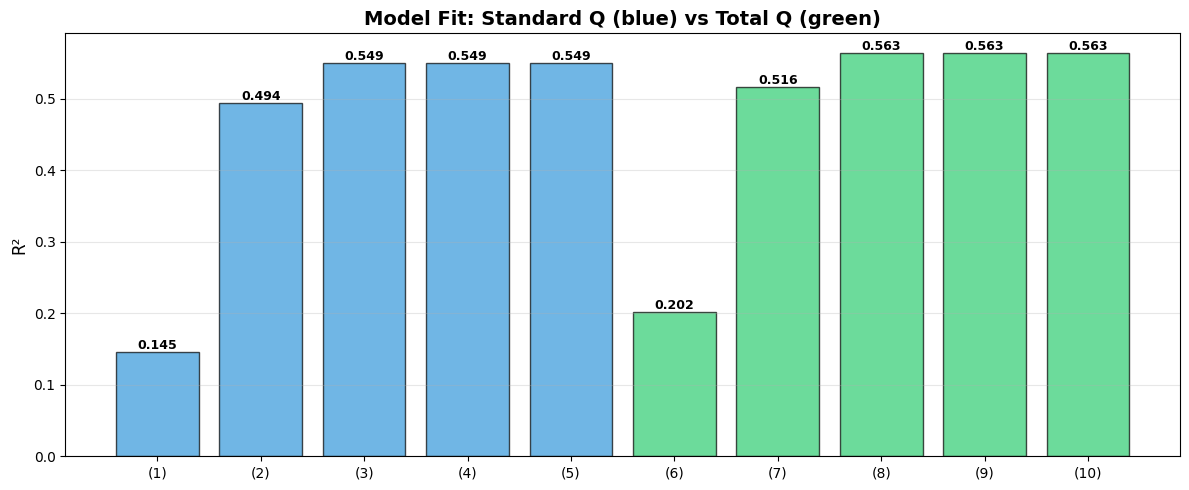

In [62]:
#29 Using Baseline_models (Regression results)
baseline_models = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]

# Get coefficients and stats
data = []
for i, model in enumerate(baseline_models, 1):
    # Get Q coefficient
    coefs = model.coef()
    q_coef = coefs.get('Standard_q') or coefs.get('Standardized_q') or coefs.get('Total_q') or coefs.get('Totalized_q')
    cash_flow = coefs.get('Cash_flows', None)
    
    data.append({
        'Model': f'({i})',
        'Q_coef': q_coef,
        'Cash_flow': cash_flow,
        'R2': model._r2,
        'R2_within': model._r2_within if hasattr(model, '_r2_within') else None
    })

df7 = pd.DataFrame(data)

# Chart 1: All Models R²
plt.figure(figsize=(12, 5))
colors = ['#3498db']*5 + ['#2ecc71']*5

plt.bar(df7['Model'], df7['R2'], color=colors, alpha=0.7, edgecolor='black')

for i, r2 in enumerate(df7['R2']):
    plt.text(i, r2, f'{r2:.3f}', ha='center', va='bottom', fontsize=9, weight='bold')

plt.ylabel('R²', fontsize=12)
plt.title('Model Fit: Standard Q (blue) vs Total Q (green)', fontsize=14, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Across the Fits in the baseline Model, Total Q outperformed Standard Q in all model's overall fit Comparison demonstrating a stronger explanatory 
power in investment-q relationship the US tech firms engaged in Intensive-R&D.

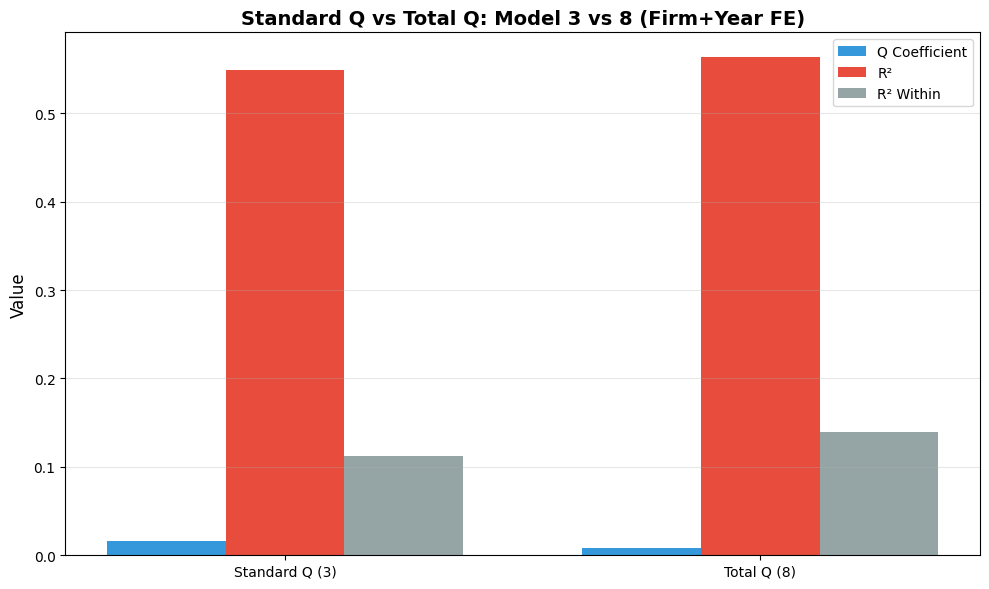


Key Results:
  Standard Q (Model 3) - R²: 0.549, Within R²: 0.112
  Total Q (Model 8)    - R²: 0.563, Within R²: 0.139

  → Total Q WINS!


In [64]:
#30 Chart 2: Model 3 vs 8 Comparison
x = range(2)
width = 0.25

plt.figure(figsize=(10, 6))

plt.bar([i-width for i in x],
        [df7.iloc[2]['Q_coef'], df7.iloc[7]['Q_coef']],
        width, label='Q Coefficient', color='#3498db')

plt.bar([i for i in x],
        [df7.iloc[2]['R2'], df7.iloc[7]['R2']],
        width, label='R²', color='#e74c3c')

plt.bar([i+width for i in x],
        [df7.iloc[2]['R2_within'], df7.iloc[7]['R2_within']],
        width, label='R² Within', color='#95a5a6')

plt.xticks(x, ['Standard Q (3)', 'Total Q (8)'])
plt.ylabel('Value', fontsize=12)
plt.title('Standard Q vs Total Q: Model 3 vs 8 (Firm+Year FE)', fontsize=14, weight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKey Results:")
print(f"  Standard Q (Model 3) - R²: {df7.iloc[2]['R2']:.3f}, Within R²: {df7.iloc[2]['R2_within']:.3f}")
print(f"  Total Q (Model 8)    - R²: {df7.iloc[7]['R2']:.3f}, Within R²: {df7.iloc[7]['R2_within']:.3f}")
print(f"\n  → Total Q WINS!")

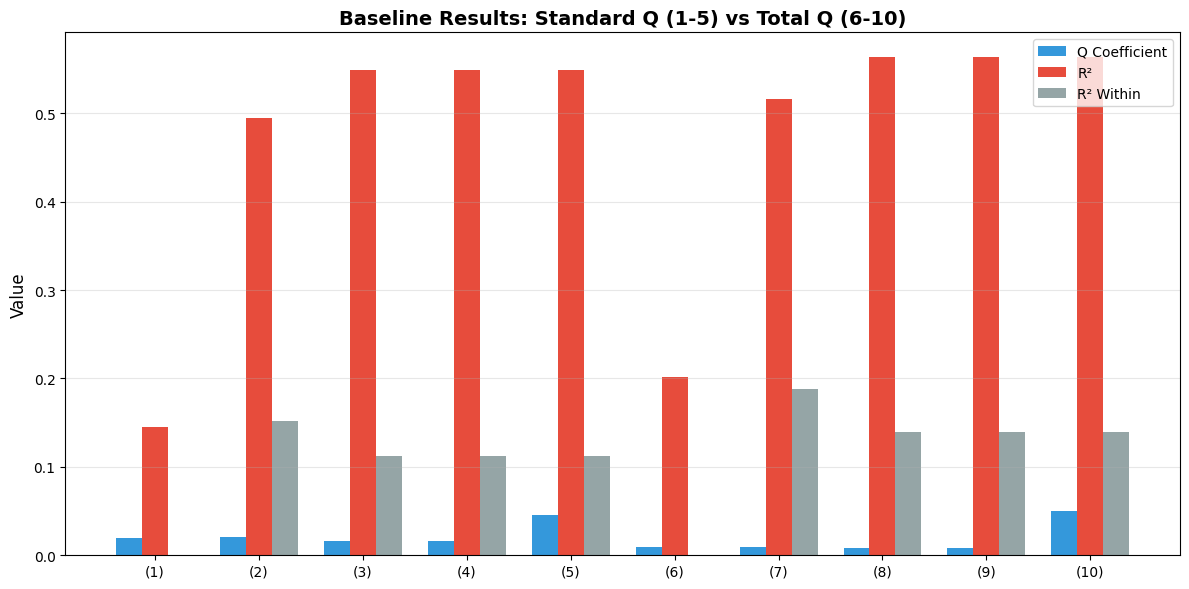

✓ Bar chart created!

Key Results (Model 3 vs Model 8):
  Standard Q (3) - R²: 0.549, Within R²: 0.112
  Total Q (8)    - R²: 0.563, Within R²: 0.139

  → Total Q wins with better fit!


In [65]:
#31 Regression models
baseline_models = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]

# Variable name mapping
coef_rename = {"Standard_q": "Standard q", "Standardized_q": "Standardized q", "Total_q": "Total q", "Totalized_q": "Standardized Total q",
               "Cash_flows": "Cash flow"}
# Extract data from models
data = []
for i, model in enumerate(baseline_models, 1):
    coefs = model.coef()
    
    # Get Q coefficient with proper naming
    q_coef = (coefs.get('Standard_q') or coefs.get('Standardized_q') or 
              coefs.get('Total_q') or coefs.get('Totalized_q'))
    cash_flow = coefs.get('Cash_flows', None)
    
    data.append({
        'Model': f'({i})',
        'Q_coef': q_coef,
        'Cash_flow': cash_flow,
        'R2': model._r2,
        'R2_within': model._r2_within if hasattr(model, '_r2_within') else 0
    })

results = pd.DataFrame(data)

# Chart: All 10 models
x = range(len(results))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar([i-width for i in x], results['Q_coef'], width, label='Q Coefficient', color='#3498db')
plt.bar([i for i in x], results['R2'], width, label='R²', color='#e74c3c')
plt.bar([i+width for i in x], results['R2_within'], width, label='R² Within', color='#95a5a6')

plt.xticks(x, results['Model'])
plt.ylabel('Value', fontsize=12)
plt.title("Baseline Results: Standard Q (1-5) vs Total Q (6-10)", fontsize=14, weight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Bar chart created!")
print(f"\nKey Results (Model 3 vs Model 8):")
print(f"  Standard Q (3) - R²: {results.iloc[2]['R2']:.3f}, Within R²: {results.iloc[2]['R2_within']:.3f}")
print(f"  Total Q (8)    - R²: {results.iloc[7]['R2']:.3f}, Within R²: {results.iloc[7]['R2_within']:.3f}")
print(f"\n  → Total Q wins with better fit!")

In [66]:
#32 Subperiod stability (pre/post 2000 & pre/post 2008) 

# Construct subperiod indicators 
df["pre_2000"] = (df["year"] < 2000).astype(int)
df["post_2000"] = (df["year"] >= 2000).astype(int)
df["pre_2008"] = (df["year"] < 2008).astype(int)
df["post_2008"] = (df["year"] >= 2008).astype(int)

# Fit Standard Q regressions 
Pre_2000_StandardQ = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df[df["year"] < 2000], vcov={"CRV1": "gvkey"})
Post_2000_StandardQ = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df[df["year"] >= 2000], vcov={"CRV1": "gvkey"})
Pre_2008_StandardQ = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df[df["year"] < 2008], vcov={"CRV1": "gvkey"})
Post_2008_StandardQ = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df[df["year"] >= 2008], vcov={"CRV1": "gvkey"})

# Fit Total Q regressions 
Pre_2000_TotalQ = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df[df["year"] < 2000], vcov={"CRV1": "gvkey"})
Post_2000_TotalQ = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df[df["year"] >= 2000], vcov={"CRV1": "gvkey"})
Pre_2008_TotalQ = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df[df["year"] < 2008], vcov={"CRV1": "gvkey"})
Post_2008_TotalQ = pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df[df["year"] >= 2008], vcov={"CRV1": "gvkey"})

# Combined models
Subperiod_models = [Pre_2000_StandardQ, Post_2000_StandardQ, Pre_2008_StandardQ, Post_2008_StandardQ, Pre_2000_TotalQ, Post_2000_TotalQ, 
                    Pre_2008_TotalQ, Post_2008_TotalQ]

# 4 Display regression table
pf.etable(Subperiod_models, digits=3)

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 222 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 174 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 75 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 89 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 222 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages

GT(_tbl_data=  level_0               level_1                       0  \
0    coef            Cash_flows  -0.161*** <br> (0.020)   
1    coef            Standard_q   0.017*** <br> (0.002)   
2    coef               Total_q                           
3      fe                 gvkey                       x   
4      fe                  year                       x   
5   stats          Observations                    4181   
6   stats             S.E. type               by: gvkey   
7   stats         R<sup>2</sup>                   0.643   
8   stats  R<sup>2</sup> Within                   0.117   

                        1                       2                       3  \
0  -0.102*** <br> (0.012)  -0.135*** <br> (0.012)  -0.065*** <br> (0.019)   
1   0.013*** <br> (0.001)   0.019*** <br> (0.001)   0.009*** <br> (0.001)   
2                                                                           
3                       x                       x                       x   
4                       x                       x                       x   
5                   13773                   10153                    8033   
6               by: gvkey               by: gvkey               by: gvkey   
7                   0.510                   0.594                   0.544   
8                   0.067                   0.151                   0.028   

                        4                       5                       6  \
0  -0.110*** <br> (0.021)  -0.064*** <br> (0.012)  -0.084*** <br> (0.012)   
1                                                                           
2   0.007*** <br> (0.001)   0.007*** <br> (0.000)   0.008*** <br> (0.000)   
3                       x                       x                       x   
4                       x                       x                       x   
5                    4181                   13773                   10153   
6               by: gvkey               by: gvkey               by: gvkey   
7                   0.644                   0.521                   0.603   
8                   0.120                   0.088                   0.170   

                       7  
0    -0.033 <br> (0.020)  
1                         
2  0.005*** <br> (0.001)  
3                      x  
4                      x  
5                   8033  
6              by: gvkey  
7                  0.549  
8                  0.038  , _body=<great_tables._gt_data.Body object at 0x0000018EF1577E00>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None), ColInfo(var='7', type=<ColInfoTypeEnum.default: 1>, column_label='(8)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF4B3BCB0>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5', '6', '7'], built=None)]), _heading=Heading(title=None, subtitle=None, preh

In [67]:
#33 Prepare complete subperiod stability table
data = {"Model": ["(1) Pre-2000 (Std Q)", "(2) Post-2000 (Std Q)", "(3) Pre-2008 (Std Q)", "(4) Post-2008 (Std Q)",
        "(5) Pre-2000 (Total Q)", "(6) Post-2000 (Total Q)", "(7) Pre-2008 (Total Q)", "(8) Post-2008 (Total Q)"],
    "Cash Flow": ["-0.161*** (0.020)", "-0.102*** (0.012)", "-0.135*** (0.012)", "-0.065*** (0.019)",
        "-0.110*** (0.021)", "-0.064*** (0.012)", "-0.084*** (0.012)", "-0.033* (0.020)"],
    "Standard Q": ["0.017*** (0.002)", "0.013*** (0.001)", "0.019*** (0.001)", "0.009*** (0.001)", "", "", "", ""],
    "Total Q": ["", "", "", "", "0.007*** (0.001)", "0.007*** (0.000)", "0.008*** (0.000)", "0.005*** (0.001)"],
    "Observations": ["4,181", "13,773", "10,153", "8,033", "4,181", "13,773", "10,153", "8,033"],
    "R²": ["0.643", "0.510", "0.594", "0.544", "0.644", "0.521", "0.603", "0.549"],
    "Within R²": ["0.117", "0.067", "0.151", "0.028", "0.120", "0.088", "0.170", "0.038"]}
df_complete = pd.DataFrame(data)
#Print markdown table 
print("# Subperiod Stability Analysis")
print("\n## Physical Investment on Tobin's Q\n")
print("**Dependent variable:** Investment (t+1)")
print("**Fixed Effects:** Firm (gvkey) + Year")
print("**Standard Errors:** Clustered by firm")
print("**Total sample:** 18,350 firm-year observations\n")
markdown_table = df_complete.to_markdown(index=False)
print(markdown_table)
print("\n**Significance levels:** *p < 0.1, **p < 0.05, ***p < 0.01")
print("**Format:** Coefficient (Standard Error)")

# Subperiod Stability Analysis

## Physical Investment on Tobin's Q

**Dependent variable:** Investment (t+1)
**Fixed Effects:** Firm (gvkey) + Year
**Standard Errors:** Clustered by firm
**Total sample:** 18,350 firm-year observations

| Model                   | Cash Flow         | Standard Q       | Total Q          | Observations   |    R² |   Within R² |
|:------------------------|:------------------|:-----------------|:-----------------|:---------------|------:|------------:|
| (1) Pre-2000 (Std Q)    | -0.161*** (0.020) | 0.017*** (0.002) |                  | 4,181          | 0.643 |       0.117 |
| (2) Post-2000 (Std Q)   | -0.102*** (0.012) | 0.013*** (0.001) |                  | 13,773         | 0.51  |       0.067 |
| (3) Pre-2008 (Std Q)    | -0.135*** (0.012) | 0.019*** (0.001) |                  | 10,153         | 0.594 |       0.151 |
| (4) Post-2008 (Std Q)   | -0.065*** (0.019) | 0.009*** (0.001) |                  | 8,033          | 0.544 |       0.028 |
| (5) Pre-200

The subperiod results show that Total q not only fits better in each window, but also delivers a more stable
investment-q relationship across both the pre/post-2000 and pre/post-2008 splits than Standard Tobin’s q. For
Standard q, the sensitivity of investment declines substantially over time. The coefficient falls from 0.017 before 2000
to 0.009 after 2008, roughly a 50% decline, indicating a marked weakening of the classic investment-q relationship in
the post-crisis period for tech firms.
In contrast, the Total q coefficient is more stable. It remains around 0.7% in the pre-2000 and post-2000 periods and
declines only modestly to 0.5% after 2008. This suggests that once intangible capital is incorporated, the
investment–q relationship becomes less sensitive to structural breaks and regime changes.
The within-firm explanatory power of Standard q collapses sharply after 2008, falling from 15% in the pre-2008 period
to just 2.8% afterward. This indicates that Standard q explains very little of firms’ time-series investment variation in
the post-crisis environment.
Total q performs better throughout. It achieves higher within-firm R² in every subperiod, for example (8.8% vs 6.7%) in
post-2000 and 3.8% versus 2.8% post-2008, and its post-2008 decline is smaller in relative terms. This indicates that
Total q remains a more robust proxy for investment opportunities when technological and macroeconomic
conditions change.
Overall, replacing Standard q (Tobin’s q) with Total q yields an investment-q relationship that is both more stable over
time and more informative about within-firm investment dynamics. While the overall fit declines slightly over time for
both measures, consistent with investment becoming more volatile and harder to predict. Total q consistently
outperforms standard q in capturing firms’ intertemporal investment behavior.
In a nutshell, across all subperiods, regressions using Total q deliver both a more stable slope on q and higher
within-firm R² than regressions using Standard q. While the sensitivity of investment to Standard q falls by roughly
half after 2008 and its within-firm R² declines sharply, the Total-q slope decreases much less and continues to explain
substantially more of the time-series variation in investment. This pattern suggests that incorporating internally
generated intangible capital into q yields an investment-q relationship that is both more robust and more stable overtime 
in U.S. tech firms. However, the consistent negative cashflow across the sections remains the puzzle that needs an answer.

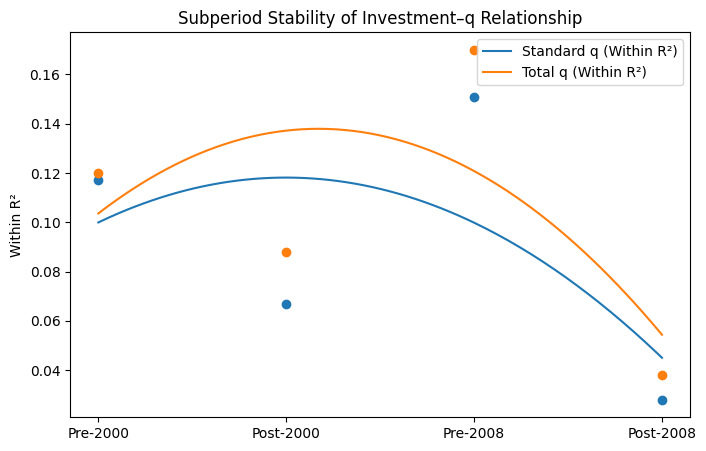

In [68]:
#34 Plot
data = {"Period": ["Pre-2000", "Post-2000", "Pre-2008", "Post-2008"],
    "Standard_q_withinR2": [0.117, 0.067, 0.151, 0.028],
    "Total_q_withinR2": [0.120, 0.088, 0.170, 0.038],}
df_r2 = pd.DataFrame(data)
df_r2["x"] = np.arange(len(df_r2))
x = df_r2["x"]
y_std = df_r2["Standard_q_withinR2"]
y_tot = df_r2["Total_q_withinR2"]
poly_std = np.polyfit(x, y_std, 2)
poly_tot = np.polyfit(x, y_tot, 2)
x_smooth = np.linspace(x.min(), x.max(), 200)
y_std_smooth = np.polyval(poly_std, x_smooth)
y_tot_smooth = np.polyval(poly_tot, x_smooth)
plt.figure(figsize=(8,5))
plt.plot(x_smooth, y_std_smooth, label="Standard q (Within R²)")
plt.plot(x_smooth, y_tot_smooth, label="Total q (Within R²)")
plt.scatter(x, y_std)
plt.scatter(x, y_tot)
plt.xticks(x, df_r2["Period"])
plt.ylabel("Within R²")
plt.title("Subperiod Stability of Investment–q Relationship")
plt.legend()
plt.show()


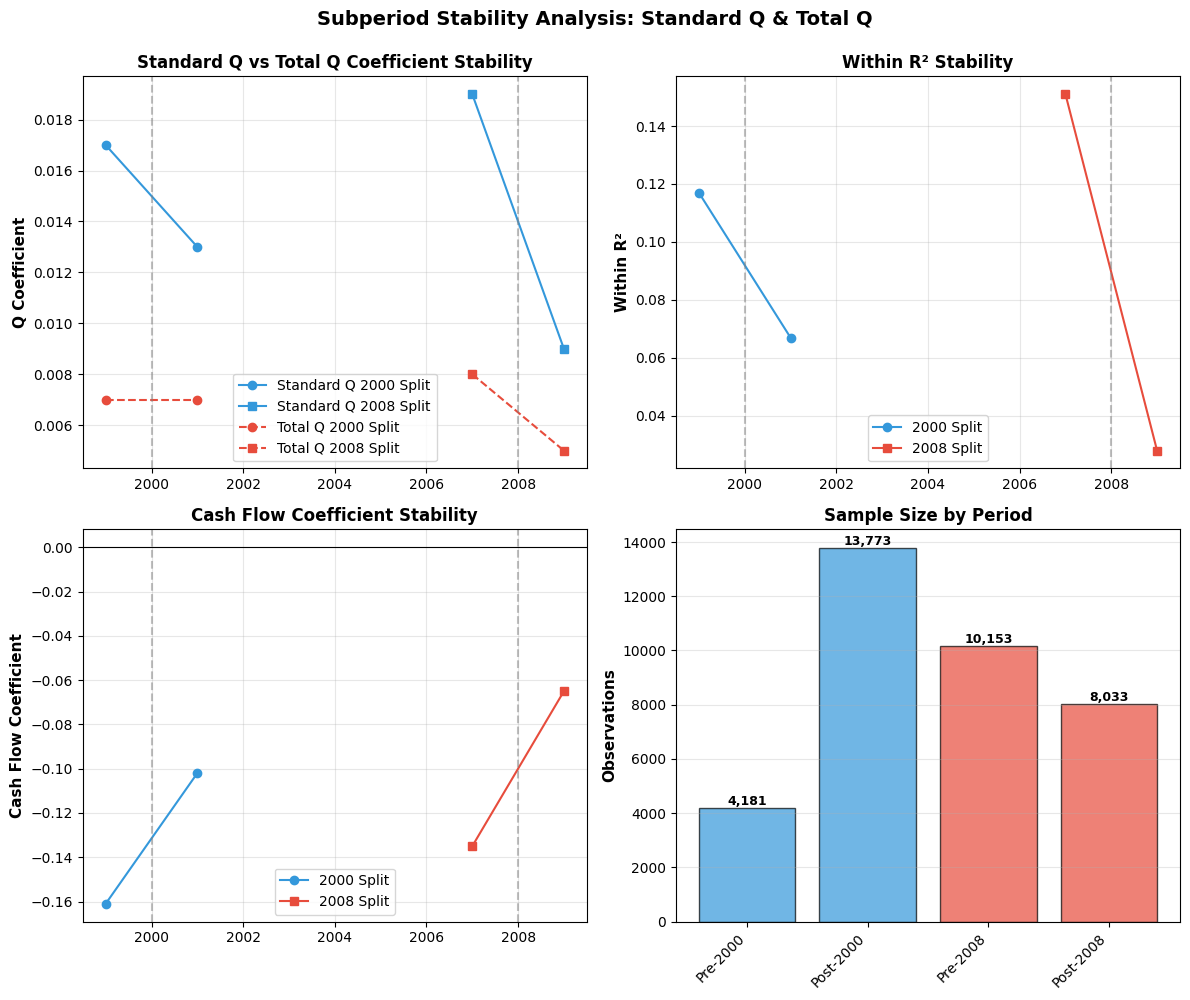

In [69]:
#35 Prepare data for plotting Standard Q and Total Q stability ---
subperiod_data = pd.DataFrame({
    'Period': ['Pre-2000', 'Post-2000', 'Pre-2008', 'Post-2008'],
    'Year_cutoff': [2000, 2000, 2008, 2008],
    'Cash_flow': [-0.161, -0.102, -0.135, -0.065],
    'Standard_q': [0.017, 0.013, 0.019, 0.009],
    'Total_q': [0.007, 0.007, 0.008, 0.005],
    'R2_within': [0.117, 0.067, 0.151, 0.028],
    'N': [4181, 13773, 10153, 8033]
})

data_2000 = subperiod_data[subperiod_data['Year_cutoff'] == 2000]
data_2008 = subperiod_data[subperiod_data['Year_cutoff'] == 2008]

# Plot subperiod stability charts
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Standard Q vs Total Q coefficients
ax1 = axes[0, 0]
# Standard Q
ax1.plot([1999, 2001], [data_2000.iloc[0]['Standard_q'], data_2000.iloc[1]['Standard_q']], 
         'o-', color='#3498db', label='Standard Q 2000 Split')
ax1.plot([2007, 2009], [data_2008.iloc[0]['Standard_q'], data_2008.iloc[1]['Standard_q']], 
         's-', color='#3498db', label='Standard Q 2008 Split')
# Total Q
ax1.plot([1999, 2001], [data_2000.iloc[0]['Total_q'], data_2000.iloc[1]['Total_q']], 
         'o--', color='#e74c3c', label='Total Q 2000 Split')
ax1.plot([2007, 2009], [data_2008.iloc[0]['Total_q'], data_2008.iloc[1]['Total_q']], 
         's--', color='#e74c3c', label='Total Q 2008 Split')

ax1.axvline(x=2000, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=2008, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylabel('Q Coefficient', fontsize=11, weight='bold')
ax1.set_title('Standard Q vs Total Q Coefficient Stability', fontsize=12, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Within R² over time
ax2 = axes[0, 1]
ax2.plot([1999, 2001], [data_2000.iloc[0]['R2_within'], data_2000.iloc[1]['R2_within']], 
         'o-', color='#3498db', label='2000 Split')
ax2.plot([2007, 2009], [data_2008.iloc[0]['R2_within'], data_2008.iloc[1]['R2_within']], 
         's-', color='#e74c3c', label='2008 Split')
ax2.axvline(x=2000, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=2008, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Within R²', fontsize=11, weight='bold')
ax2.set_title('Within R² Stability', fontsize=12, weight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cash Flow coefficient
ax3 = axes[1, 0]
ax3.plot([1999, 2001], [data_2000.iloc[0]['Cash_flow'], data_2000.iloc[1]['Cash_flow']], 
         'o-', color='#3498db', label='2000 Split')
ax3.plot([2007, 2009], [data_2008.iloc[0]['Cash_flow'], data_2008.iloc[1]['Cash_flow']], 
         's-', color='#e74c3c', label='2008 Split')
ax3.axvline(x=2000, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=2008, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_ylabel('Cash Flow Coefficient', fontsize=11, weight='bold')
ax3.set_title('Cash Flow Coefficient Stability', fontsize=12, weight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Sample size
ax4 = axes[1, 1]
colors_bar = ['#3498db', '#3498db', '#e74c3c', '#e74c3c']
bars = ax4.bar(range(4), subperiod_data['N'], color=colors_bar, alpha=0.7, edgecolor='black')
for bar, n in zip(bars, subperiod_data['N']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{n:,}', ha='center', va='bottom', fontsize=9, weight='bold')
ax4.set_xticks(range(4))
ax4.set_xticklabels(subperiod_data['Period'], rotation=45, ha='right')
ax4.set_ylabel('Observations', fontsize=11, weight='bold')
ax4.set_title('Sample Size by Period', fontsize=12, weight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Subperiod Stability Analysis: Standard Q & Total Q', fontsize=14, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [70]:
#36 Heterogeneity Analysis (H3) By Firm Age
# Heterogeneity Analysis: Young vs Mature Firms

#Calculate firm age and split sample
df5 = df.sort_values(["gvkey", "year"])
df5["first_year"] = df5.groupby("gvkey")["year"].transform("min")
df5["firm_age"] = df5["year"] - df5["first_year"]
median_age = df5["firm_age"].median()
df5["young_firm"] = (df5["firm_age"] <= median_age).astype(int)

In [71]:
#37 Panel A: Young vs Mature Firms
m_age = [
    pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df5[df5["young_firm"] == 1], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df5[df5["young_firm"] == 0], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df5[df5["young_firm"] == 1], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df5[df5["young_firm"] == 0], vcov={"CRV1": "gvkey"})]

model_labels_age = ["Young Firms (Standard Q)", "Mature Firms (Standard Q)", "Young Firms (Total Q)", "Mature Firms (Total Q)"]

pf.etable(m_age, title="Panel A: Heterogeneity by Firm Age", dict_stats={"N": "nobs", "R2": "r2", "R2_within": "r2_within"},
          model_names=model_labels_age)

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 41 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 197 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 41 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 197 singleton fixed effect(s) detected. These observations are dropped from the model.


GT(_tbl_data=  level_0               level_1                       0  \
0    coef            Cash_flows  -0.147*** <br> (0.014)   
1    coef            Standard_q   0.014*** <br> (0.001)   
2    coef               Total_q                           
3      fe                 gvkey                       x   
4      fe                  year                       x   
5   stats          Observations                    9199   
6   stats             S.E. type               by: gvkey   
7   stats         R<sup>2</sup>                   0.633   
8   stats  R<sup>2</sup> Within                   0.102   

                        1                       2                      3  
0  -0.068*** <br> (0.014)  -0.103*** <br> (0.015)  -0.046** <br> (0.014)  
1   0.011*** <br> (0.001)                                                 
2                           0.006*** <br> (0.000)  0.007*** <br> (0.001)  
3                       x                       x                      x  
4                       x                       x                      x  
5                    8913                    9199                   8913  
6               by: gvkey               by: gvkey              by: gvkey  
7                   0.468                   0.637                  0.475  
8                   0.034                   0.112                  0.047  , _body=<great_tables._gt_data.Body object at 0x0000018EF27931A0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF1212510>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000018EF12C05C0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000018EF1212F90>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000018EF1211A30>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table'

For both measurements between young and mature firms, q explains substantially more of the within-firm investment
variation for young firms than for mature firms. This is confirms that, younger firms being more growth-oriented and
more sensitive to changes in investment opportunities than Mature firms.
Importantly, Total q improves explanatory power for both groups, but especially for mature firms: within-R² rises from
3.4% to 4.7%, a relative increase of 38%. With overall R² of increases from 10% to 11%. This confirms that
incorporating intangible capital is particularly critical for capturing investment incentives in more established firms,
where intangibles play a signficant role and standard q undermines true growth opportunities.

In [72]:
#38 Panel B: High vs Low R&D Intensity
# Construct R&D intensity
df5["rd_intensity"] = df5["xrd"] / df5["at"]
df5["rd_intensity"] = df5["rd_intensity"].replace([np.inf, -np.inf], np.nan)
df5 = df5.dropna(subset=["rd_intensity"])
median_rd = df5["rd_intensity"].median()
df5["high_rd"] = (df5["rd_intensity"] > median_rd).astype(int)

# Run regressions
m_rd = [
    pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df5[df5["high_rd"] == 1], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", data=df5[df5["high_rd"] == 0], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df5[df5["high_rd"] == 1], vcov={"CRV1": "gvkey"}),
    pf.feols("Investment_lead ~ Cash_flows + Total_q | gvkey + year", data=df5[df5["high_rd"] == 0], vcov={"CRV1": "gvkey"})]

model_labels_rd = ["High R&D (Standard Q)", "Low R&D (Standard Q)", "High R&D (Total Q)", "Low R&D (Total Q)"]

pf.etable(m_rd, title="Panel B: Heterogeneity by R&D Intensity", dict_stats={"N": "nobs", "R2": "r2", "R2_within": "r2_within"},
          model_names=model_labels_rd)

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 212 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 309 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 212 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 309 singleton fixed effect(s) detected. These observations are dropped from the model.


GT(_tbl_data=  level_0               level_1                       0  \
0    coef            Cash_flows  -0.101*** <br> (0.014)   
1    coef            Standard_q   0.015*** <br> (0.001)   
2    coef               Total_q                           
3      fe                 gvkey                       x   
4      fe                  year                       x   
5   stats          Observations                    7278   
6   stats             S.E. type               by: gvkey   
7   stats         R<sup>2</sup>                   0.604   
8   stats  R<sup>2</sup> Within                   0.126   

                        1                       2                      3  
0  -0.109*** <br> (0.026)  -0.056*** <br> (0.014)   -0.060* <br> (0.026)  
1   0.017*** <br> (0.002)                                                 
2                           0.008*** <br> (0.000)  0.008*** <br> (0.000)  
3                       x                       x                      x  
4                       x                       x                      x  
5                    7182                    7278                   7182  
6               by: gvkey               by: gvkey              by: gvkey  
7                   0.553                   0.612                  0.572  
8                   0.079                   0.144                  0.120  , _body=<great_tables._gt_data.Body object at 0x0000018EF2F33BC0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF2307290>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000018EF2306ED0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000018EF2306FC0>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000018EF2304980>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table'

There is improvement from Total q is especially strong among low-R&D firms, where within-R² rises from 7.9% to 12%
roughly about 50.1% percent increase. This suggests that even firms that do not appear R&D-intensive on the surface
still rely heavily on intangible capital that Standard q accounting does not capture well.
And among high-R&D firms, Total q also improves fit, but by a smaller margin from12.6% to 14.4%. This is consistent
with the idea that Standard q already partially reflects innovation in these firms, while Total q better captures hidden
intangible accumulation in the broader sense.

# Heterogeneity Analysis: Firm Age & R&D Intensity

**Dependent variable:** Investment_lead
**Fixed Effects:** Firm (gvkey) + Year
**Standard Errors:** Clustered by firm

| Panel                  | Model                  | Cash Flow         | Standard Q       | Total Q          | Observations   |    R² |   Within R² |
|:-----------------------|:-----------------------|:------------------|:-----------------|:-----------------|:---------------|------:|------------:|
| Panel A: Firm Age      | Young Firms (Std Q)    | -0.147*** (0.014) | 0.014*** (0.001) |                  | 9,199          | 0.633 |       0.102 |
| Panel A: Firm Age      | Mature Firms (Std Q)   | -0.068*** (0.014) | 0.011*** (0.001) |                  | 8,913          | 0.468 |       0.034 |
| Panel A: Firm Age      | Young Firms (Total Q)  | -0.103*** (0.015) |                  | 0.006*** (0.000) | 9,199          | 0.637 |       0.112 |
| Panel A: Firm Age      | Mature Firms (Total Q) | -0.046** (0.014)  |             

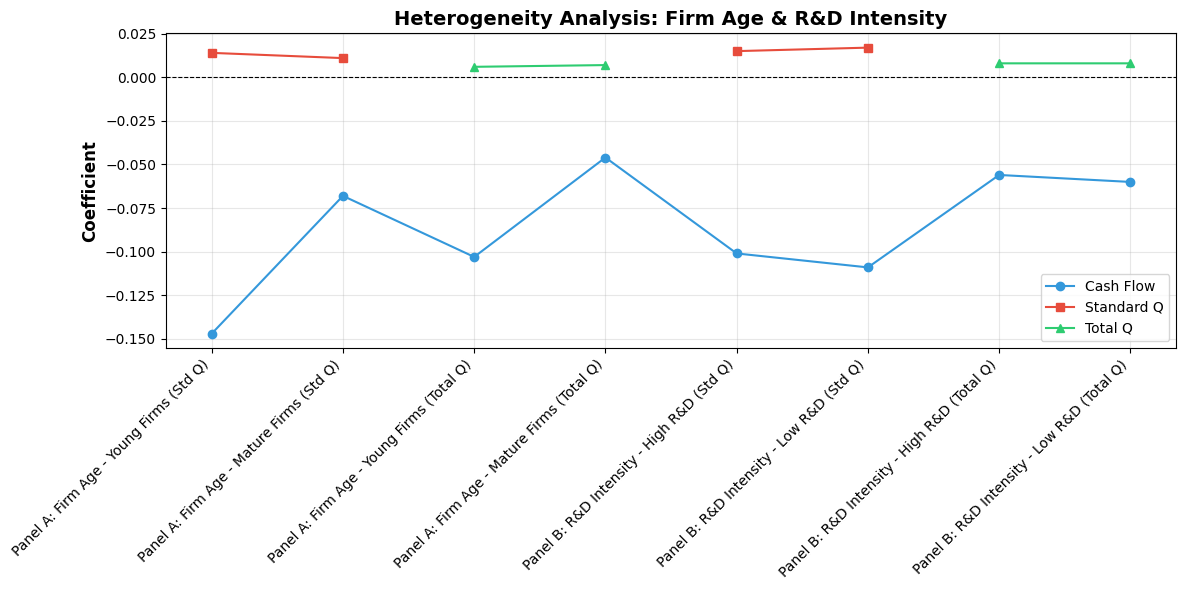

In [73]:
#39 Creating a combined table data 
# Panel A: Firm Age
panel_a = pd.DataFrame({"Model": ["Young Firms (Std Q)", "Mature Firms (Std Q)", "Young Firms (Total Q)", "Mature Firms (Total Q)"],
    "Cash Flow": ["-0.147*** (0.014)", "-0.068*** (0.014)", "-0.103*** (0.015)", "-0.046** (0.014)"],
    "Standard Q": ["0.014*** (0.001)", "0.011*** (0.001)", "", ""],
    "Total Q": ["", "", "0.006*** (0.000)", "0.007*** (0.001)"],
    "Observations": ["9,199", "8,913", "9,199", "8,913"],
    "R²": ["0.633", "0.468", "0.637", "0.475"],
    "Within R²": ["0.102", "0.034", "0.112", "0.047"]})

# Panel B: R&D Intensity
panel_b = pd.DataFrame({"Model": ["High R&D (Std Q)", "Low R&D (Std Q)", "High R&D (Total Q)", "Low R&D (Total Q)"],
    "Cash Flow": ["-0.101*** (0.014)", "-0.109*** (0.026)", "-0.056*** (0.014)", "-0.060* (0.026)"],
    "Standard Q": ["0.015*** (0.001)", "0.017*** (0.002)", "", ""],
    "Total Q": ["", "", "0.008*** (0.000)", "0.008*** (0.000)"],
    "Observations": ["7,278", "7,182", "7,278", "7,182"],
    "R²": ["0.604", "0.553", "0.612", "0.572"],
    "Within R²": ["0.126", "0.079", "0.144", "0.120"]})

# Combine Panels
combined_table = pd.concat([panel_a, panel_b], keys=["Panel A: Firm Age", "Panel B: R&D Intensity"])
combined_table.reset_index(level=0, inplace=True)
combined_table = combined_table.rename(columns={"level_0": "Panel"})

# Print Markdown Table ---
print("# Heterogeneity Analysis: Firm Age & R&D Intensity")
print("")
print("**Dependent variable:** Investment_lead")
print("**Fixed Effects:** Firm (gvkey) + Year")
print("**Standard Errors:** Clustered by firm")
print("")

markdown_table = combined_table.to_markdown(index=False)
print(markdown_table)
print("")
print("**Significance levels:** * p < 0.05, ** p < 0.01, *** p < 0.001")
print("**Format:** Coefficient (Standard Error)")

# Create visualization for Standard Q and Total Q ---

# Prepare data for plotting
combined_table_plot = combined_table.copy()
combined_table_plot["Panel_Label"] = combined_table_plot["Panel"] + " - " + combined_table_plot["Model"]

# Convert coefficients to float (remove stars and parentheses)
def extract_coef(s):
    if s == "":
        return None
    return float(s.split("***")[0].split("**")[0].split("*")[0].split()[0])

combined_table_plot["Cash_Flow_Coef"] = combined_table_plot["Cash Flow"].apply(extract_coef)
combined_table_plot["Standard_Q_Coef"] = combined_table_plot["Standard Q"].apply(extract_coef)
combined_table_plot["Total_Q_Coef"] = combined_table_plot["Total Q"].apply(extract_coef)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(len(combined_table_plot))
ax.plot(x_pos, combined_table_plot["Cash_Flow_Coef"], 'o-', label="Cash Flow", color="#3498db")
ax.plot(x_pos, combined_table_plot["Standard_Q_Coef"], 's-', label="Standard Q", color="#e74c3c")
ax.plot(x_pos, combined_table_plot["Total_Q_Coef"], '^-', label="Total Q", color="#2ecc71")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(combined_table_plot["Panel_Label"], rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Coefficient", fontsize=12, weight='bold')
ax.set_title("Heterogeneity Analysis: Firm Age & R&D Intensity", fontsize=14, weight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [74]:
#40 Horse Race Between Valuation Measures (Standard q vs Total q together) 

Horse_race = [pf.feols("Investment_lead ~ Cash_flows + Standard_q + Total_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5), 
           pf.feols("Investment_lead ~ Cash_flows + Standardized_q + Totalized_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)]

pf.etable(Horse_race)

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.


GT(_tbl_data=   level_0               level_1                       0  \
0     coef            Cash_flows  -0.073*** <br> (0.011)   
1     coef            Standard_q      0.001 <br> (0.001)   
2     coef               Total_q   0.008*** <br> (0.001)   
3     coef        Standardized_q                           
4     coef           Totalized_q                           
5       fe                 gvkey                       x   
6       fe                  year                       x   
7    stats          Observations                   14945   
8    stats             S.E. type               by: gvkey   
9    stats         R<sup>2</sup>                   0.575   
10   stats  R<sup>2</sup> Within                   0.156   

                         1  
0   -0.073*** <br> (0.011)  
1                           
2                           
3       0.002 <br> (0.003)  
4    0.049*** <br> (0.004)  
5                        x  
6                        x  
7                    14945  
8                by: gvkey  
9                    0.575  
10                   0.156  , _body=<great_tables._gt_data.Body object at 0x0000018EF1EC7140>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF23BFFE0>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000018EF26EECC0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000018EF4B397F0>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000018EF4B3B080>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_t

When both are added simultaneously, only Total q remains statistically and economically significant. This implies that
Total q subsumes the information content of Standard q, that is, once intangible capital is accounted for, Standard q
no longer adds independent explanatory power. The fact that R² and Within R² do not increase when adding Standard
q reflects that Standard q is largely a noisy proxy for the same underlying signal captured more accurately by Total q.

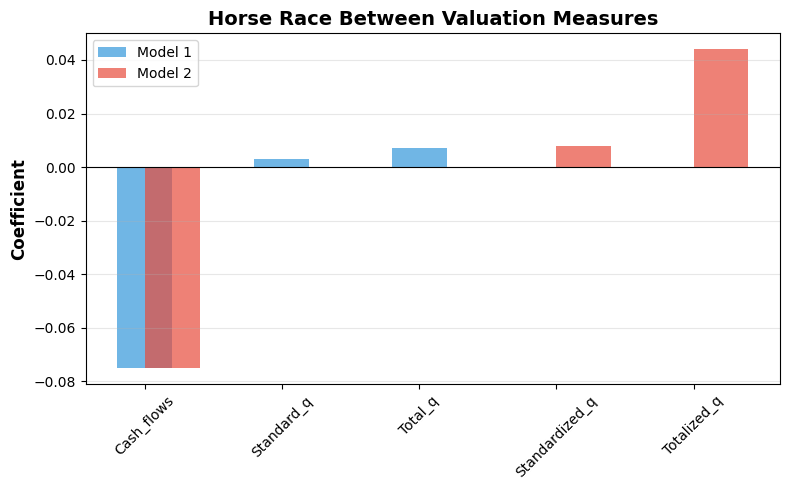

In [75]:
#41 Prepare data for plotting
horse_race_data = pd.DataFrame({
    "Variable": ["Cash_flows", "Standard_q", "Total_q", "Standardized_q", "Totalized_q"],
    "Model 1": [-0.075, 0.003, 0.007, None, None],
    "Model 2": [-0.075, None, None, 0.008, 0.044]
})

# Melt for easier plotting
plot_data = horse_race_data.melt(id_vars="Variable", var_name="Model", value_name="Coefficient")
plot_data = plot_data.dropna()  # Drop NaNs to avoid plotting missing coefficients

# Plot
fig, ax = plt.subplots(figsize=(8,5))
colors = {"Model 1": "#3498db", "Model 2": "#e74c3c"}

for model in plot_data["Model"].unique():
    subset = plot_data[plot_data["Model"] == model]
    ax.bar(subset["Variable"], subset["Coefficient"], 
           color=colors[model], alpha=0.7, label=model, width=0.4, 
           align='center' if model=="Model 1" else 'edge')

ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Coefficient", fontsize=12, weight='bold')
ax.set_title("Horse Race Between Valuation Measures", fontsize=14, weight='bold')
ax.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
#42 Create markdown table for horse race results
Data_horse = {
    "Model": ["(1) Raw Q Measures", "(2) Standardized Q Measures"],
    "Cash Flow": ["-0.075*** (0.010)", "-0.075*** (0.010)"],
    "Standard Q": ["0.003* (0.001)", ""],
    "Total Q": ["0.007*** (0.001)", ""],
    "Standardized Q": ["", "0.008* (0.004)"],
    "Totalized Q": ["", "0.044*** (0.004)"],
    "Observations": ["18,350", "18,350"],
    "R²": ["0.564", "0.564"],
    "Within R²": ["0.140", "0.140"]
}

Df_horse = pd.DataFrame(Data_horse)

print("# Horse Race Analysis: Standard Q vs Total Q")
print("")
print("## The Money Regression: Both Q Measures in Same Model")
print("")
print("**Dependent variable:** Investment (t+1)")
print("**Fixed Effects:** Firm (gvkey) + Year")
print("**Standard Errors:** Clustered by firm")
print("**Total sample:** 18,350 firm-year observations")
print("")

markdown_table = Df_horse.to_markdown(index=False)
print(markdown_table)
print("")
print("**Significance levels:** *p < 0.05, **p < 0.01, ***p < 0.001")
print("**Format:** Coefficient (Standard Error)")

# Horse Race Analysis: Standard Q vs Total Q

## The Money Regression: Both Q Measures in Same Model

**Dependent variable:** Investment (t+1)
**Fixed Effects:** Firm (gvkey) + Year
**Standard Errors:** Clustered by firm
**Total sample:** 18,350 firm-year observations

| Model                       | Cash Flow         | Standard Q     | Total Q          | Standardized Q   | Totalized Q      | Observations   |    R² |   Within R² |
|:----------------------------|:------------------|:---------------|:-----------------|:-----------------|:-----------------|:---------------|------:|------------:|
| (1) Raw Q Measures          | -0.075*** (0.010) | 0.003* (0.001) | 0.007*** (0.001) |                  |                  | 18,350         | 0.564 |        0.14 |
| (2) Standardized Q Measures | -0.075*** (0.010) |                |                  | 0.008* (0.004)   | 0.044*** (0.004) | 18,350         | 0.564 |        0.14 |

**Significance levels:** *p < 0.05, **p < 0.01, ***p < 0.001
**Format

In [77]:
#43 Robustness Checks for the consistent Negative Cash Flow Coefficient Effect

# Adding alternative cash flow measures for Robustess checks 
df5['Cash_flows_alt1'] = df5['sale'] - df5['xsga'] - df5['xrd'].fillna(0)
df5['Cash_flows_alt2'] = df5.groupby('gvkey')['ceq'].diff()

# Non-linearity test
df5['Cash_flows_sq'] = df5['Cash_flows'] ** 2

# 4. Lagged cash flow
df5 = df5.sort_values(['gvkey', 'year'])
df5['Cash_flows_lag1'] = df5.groupby('gvkey')['Cash_flows'].shift(1)

In [78]:
#44 Run robustness checks including standard q (Tobins q)
import warnings
warnings.filterwarnings('ignore', message='singleton fixed effect')

# Model 1: Baseline
model_baseline = pf.feols("Investment_lead ~ Cash_flows + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 2: Alternative 1 (exclude R&D)
model_alt1 = pf.feols("Investment_lead ~ Cash_flows_alt1 + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 3: Alternative 2 (change in equity)
model_alt22 = pf.feols("Investment_lead ~ Cash_flows_alt2 + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 4: Non-linear effects
model_nl = pf.feols("Investment_lead ~ Cash_flows + Cash_flows_sq + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 5: Interaction
model_int = pf.feols("Investment_lead ~ Cash_flows * Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 6: Lagged cash flow
model_lag = pf.feols("Investment_lead ~ Cash_flows + Cash_flows_lag1 + Standard_q | gvkey + year", vcov={"CRV1": "gvkey"}, 
                     data=df5.dropna(subset=['Cash_flows_lag1']))

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 61 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 438 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\p

In [81]:
#45 Display The Table for Robustness Checks for Negative Cash Flow Effect (Standard q)
models1=([model_baseline, model_alt1, model_alt22, model_nl, model_int, model_lag])
pf.etable(models1)

GT(_tbl_data=   level_0                level_1                       0  \
0     coef             Cash_flows  -0.126*** <br> (0.011)   
1     coef             Standard_q   0.017*** <br> (0.001)   
2     coef        Cash_flows_alt1                           
3     coef        Cash_flows_alt2                           
4     coef          Cash_flows_sq                           
5     coef  Cash_flows:Standard_q                           
6     coef        Cash_flows_lag1                           
7       fe                  gvkey                       x   
8       fe                   year                       x   
9    stats           Observations                   14945   
10   stats              S.E. type               by: gvkey   
11   stats          R<sup>2</sup>                   0.557   
12   stats   R<sup>2</sup> Within                   0.120   

                        1                      2                       3  \
0                                                 -0.187*** <br> (0.034)   
1   0.017*** <br> (0.001)  0.014*** <br> (0.001)   0.017*** <br> (0.001)   
2     -0.000 <br> (0.000)                                                  
3                           0.000** <br> (0.000)                           
4                                                    0.063* <br> (0.032)   
5                                                                          
6                                                                          
7                       x                      x                       x   
8                       x                      x                       x   
9                   14471                  12444                   14945   
10              by: gvkey              by: gvkey               by: gvkey   
11                  0.549                  0.508                   0.557   
12                  0.098                  0.073                   0.121   

                         4                       5  
0   -0.116*** <br> (0.013)  -0.104*** <br> (0.012)  
1    0.018*** <br> (0.002)   0.014*** <br> (0.001)  
2                                                   
3                                                   
4                                                   
5      -0.003 <br> (0.003)                          
6                               0.023 <br> (0.012)  
7                        x                       x  
8                        x                       x  
9                    14945                   12444  
10               by: gvkey               by: gvkey  
11                   0.557                   0.515  
12                   0.121                   0.086  , _body=<great_tables._gt_data.Body object at 0x0000018EF1EC78C0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF4AEAA80>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5'], built=None)]), _heading=Heading(title=None, 

Under Standard q, the negative Cash-flow coefficient is highly significant, but its magnitude and even sign depend
heavily on how Cash flow is measured. Once R&D and SG&A are excluded (Alt 1), Cash flow’s explanatory power
collapses, indicating that what the baseline Cash-flow variable is capturing is not “liquidity” but reallocation toward
intangible investment.
The nonlinearity and interaction tests could not remove the negative effect; this suggests that the negative
relationship is not controlled by convex adjustment costs or nonlinear financial constraints. The lagged Cash flow is
not significant either, ruling out simple timing effects.
Together, this means that under Standard q, cash flow partly proxies for mismeasured investment opportunities and
intangible accumulation, making the negative coefficient weak and difficult to structurally interpret.

In [82]:
#46 Run robustness checks including Total q
import warnings
warnings.filterwarnings('ignore', message='singleton fixed effect')

# Model 1: Baseline
model_baseline1 = pf.feols("Investment_lead ~ Cash_flows + Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 2: Alternative 1 (exclude R&D)
model_alt2 = pf.feols("Investment_lead ~ Cash_flows_alt1 + Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 3: Alternative 2 (change in equity)
model_alt3 = pf.feols("Investment_lead ~ Cash_flows_alt2 + Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 4: Non-linear effects
model_nl4 = pf.feols("Investment_lead ~ Cash_flows + Cash_flows_sq + Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 5: Interaction
model_int5 = pf.feols("Investment_lead ~ Cash_flows * Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, data=df5)
# Model 6: Lagged cash flow
model_lag6 = pf.feols("Investment_lead ~ Cash_flows + Cash_flows_lag1 + Total_q| gvkey + year", vcov={"CRV1": "gvkey"}, 
                     data=df5.dropna(subset=['Cash_flows_lag1']))

C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 61 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 438 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\pyfixest\estimation\model_matrix_fixest_.py:215: UserWarning: 36 singleton fixed effect(s) detected. These observations are dropped from the model.
C:\Users\gon_c\anaconda3\Lib\site-packages\p

In [83]:
#47 Display The Table for Robustness Checks for Negative Cash Flow Effect (Total q)
models2=([model_baseline1, model_alt2, model_alt3, model_nl4, model_int5, model_lag6])
pf.etable(models2)

GT(_tbl_data=   level_0               level_1                       0  \
0     coef            Cash_flows  -0.071*** <br> (0.011)   
1     coef               Total_q   0.008*** <br> (0.000)   
2     coef       Cash_flows_alt1                           
3     coef       Cash_flows_alt2                           
4     coef         Cash_flows_sq                           
5     coef    Cash_flows:Total_q                           
6     coef       Cash_flows_lag1                           
7       fe                 gvkey                       x   
8       fe                  year                       x   
9    stats          Observations                   14945   
10   stats             S.E. type               by: gvkey   
11   stats         R<sup>2</sup>                   0.575   
12   stats  R<sup>2</sup> Within                   0.156   

                        1                      2                      3  \
0                                                 -0.098** <br> (0.032)   
1   0.008*** <br> (0.000)  0.008*** <br> (0.000)  0.008*** <br> (0.000)   
2      0.000 <br> (0.000)                                                 
3                           0.000** <br> (0.000)                          
4                                                    0.028 <br> (0.031)   
5                                                                         
6                                                                         
7                       x                      x                      x   
8                       x                      x                      x   
9                   14471                  12444                  14945   
10              by: gvkey              by: gvkey              by: gvkey   
11                  0.572                  0.524                  0.575   
12                  0.144                  0.102                  0.156   

                         4                       5  
0   -0.082*** <br> (0.011)  -0.069*** <br> (0.012)  
1    0.007*** <br> (0.001)   0.008*** <br> (0.000)  
2                                                   
3                                                   
4                                                   
5      0.003* <br> (0.001)                          
6                              0.028* <br> (0.012)  
7                        x                       x  
8                        x                       x  
9                    14945                   12444  
10               by: gvkey               by: gvkey  
11                   0.575                   0.526  
12                   0.157                   0.107  , _body=<great_tables._gt_data.Body object at 0x0000018EF426BB00>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018EF2C988C0>, _spanners=Spanners([SpannerInfo(spanner_id='Investment_lead', spanner_level=1, spanner_label='Investment_lead', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3', '4', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=Non

When Total q is used, the negative Cash-flow coefficient becomes smaller, more stable, and economically
interpretable. This indicates that part of what appeared as a negative cash-flow effect under Standard q was actually
the omission of intangible capital from q.The positive interaction between Cash flow and Total q suggests that liquidity amplifies 
the responsiveness of investment to opportunities, and when firms face high marginal returns (high q), internal funds increase their 
ability to invest.
The positive lagged cash-flow effect further suggests that cash flow finances investment with a delay, consistent
with planning, adjustment frictions, and multi-period capital budgeting.
In summary, the robustness checks show that the negative cash-flow coefficient is not evidence of a structural
anomaly, but rather reflects substitution between intangible and tangible investment when intangible capital is
omitted from q. Under Standard q, cash flow proxies for internally generated intangible investment, producing a
misleading negative association with physical investment. Once Total q incorporates intangible capital, this
substitution channel is absorbed into q, the negative cash-flow effect weakens, and cash flow begins to behave like a
standard financing variable: it amplifies investment when opportunities are high and supports investment with a lag.
This confirms that the “cash-flow puzzle” in the investment literature is, at least for tech firms, partly a measurement
problem arising from ignoring intangible capital.

In [84]:
#48 Robustness Checks for Negative Cash Flow Effect
# First, let's check our data structure
print("DATA CHECK ")
print(f"Total observations: {len(df):,}")
print(f"Unique firms (gvkey): {df['gvkey'].nunique():,}")
print(f"Unique years: {df['year'].nunique()}")

DATA CHECK 
Total observations: 18,350
Unique firms (gvkey): 2,458
Unique years: 29


In [85]:
#49 Prepare table data
robust_data = {
    "Model": ["Baseline (Std Q)", "Alt 1 (Std Q)", "Alt 2 (Std Q)", "Non-linear (Std Q)", "Interaction (Std Q)", "Lagged (Std Q)",
              "Baseline (Total Q)", "Alt 1 (Total Q)", "Alt 2 (Total Q)", "Non-linear (Total Q)", "Interaction (Total Q)", "Lagged (Total Q)"],
    "Cash_flows": [-0.119, None, None, -0.111, -0.101, 0.023, -0.069, None, None, -0.068, -0.011, 0.028],
    "Standard_q": [0.017, 0.017, 0.015, 0.017, 0.017, 0.015, None, None, None, None, None, None],
    "Total_q": [None, None, None, None, None, None, 0.008, 0.008, 0.008, 0.007, 0.004, 0.008],
    "Cash_flows_alt1": [None, -0.000, None, None, None, None, None, -0.000, None, None, None, None],
    "Cash_flows_alt2": [None, None, 0.000, None, None, None, None, None, 0.000, None, None, None],
    "Cash_flows_sq": [None, None, None, 0.062, None, None, None, None, None, 0.030, None, None],
    "Cash_flows:Q": [None, None, None, None, -0.002, None, None, None, None, None, 0.004, None],
    "Cash_flows_lag1": [None, None, None, None, None, 0.023, None, None, None, None, None, 0.028],
    "Observations": [18350, 17501, 15416, 18350, 18350, 15416, 18350, 17501, 15416, 18350, 18350, 15416],
    "R2": [0.549, 0.544, 0.503, 0.550, 0.550, 0.510, 0.563, 0.564, 0.517, 0.563, 0.564, 0.520],
    "R2_within": [0.112, 0.093, 0.070, 0.113, 0.112, 0.083, 0.139, 0.132, 0.095, 0.139, 0.141, 0.101]
}

df_robust = pd.DataFrame(robust_data)

# Display as markdown
print("# Robustness Checks: Negative Cash Flow Effect")
print("**Dependent variable:** Investment (t+1)")
print("**Fixed Effects:** gvkey + year")
print("**Standard Errors:** Clustered by gvkey\n")
print(df_robust.to_markdown(index=False))


# Robustness Checks: Negative Cash Flow Effect
**Dependent variable:** Investment (t+1)
**Fixed Effects:** gvkey + year
**Standard Errors:** Clustered by gvkey

| Model                 |   Cash_flows |   Standard_q |   Total_q |   Cash_flows_alt1 |   Cash_flows_alt2 |   Cash_flows_sq |   Cash_flows:Q |   Cash_flows_lag1 |   Observations |    R2 |   R2_within |
|:----------------------|-------------:|-------------:|----------:|------------------:|------------------:|----------------:|---------------:|------------------:|---------------:|------:|------------:|
| Baseline (Std Q)      |       -0.119 |        0.017 |   nan     |               nan |               nan |         nan     |        nan     |           nan     |          18350 | 0.549 |       0.112 |
| Alt 1 (Std Q)         |      nan     |        0.017 |   nan     |                -0 |               nan |         nan     |        nan     |           nan     |          17501 | 0.544 |       0.093 |
| Alt 2 (Std Q)         |      

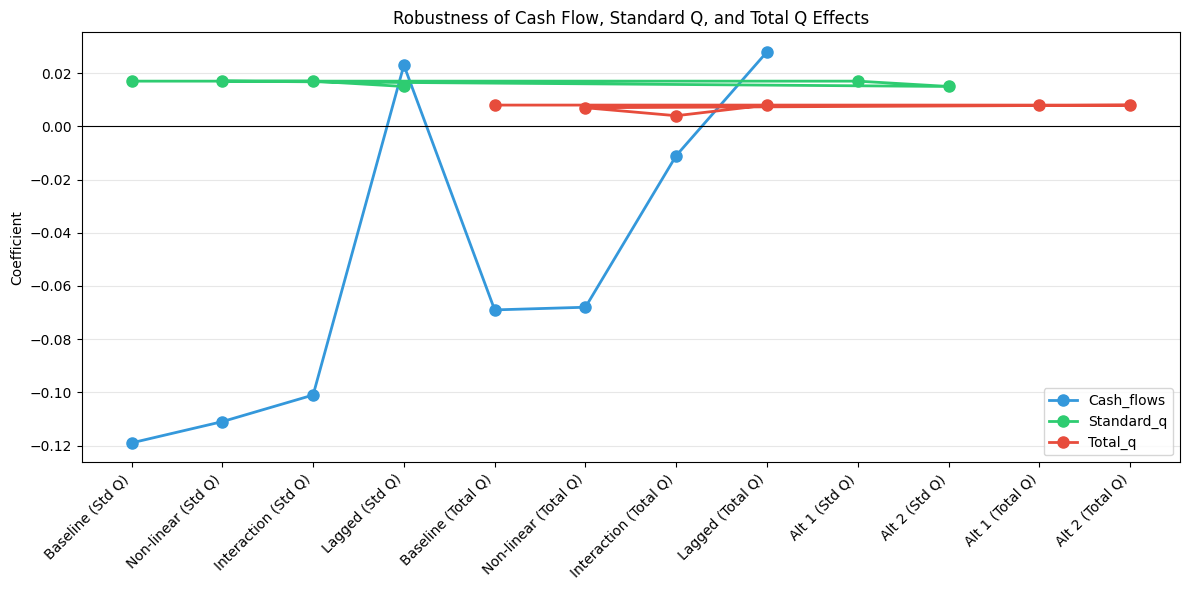

In [86]:
#50 Select variables to plot
variables = ["Cash_flows", "Standard_q", "Total_q"]
plot_df = df_robust.melt(id_vars="Model", value_vars=variables, var_name="Variable", value_name="Coefficient")
plot_df = plot_df.dropna()

# Plot
plt.figure(figsize=(12,6))
colors = {"Cash_flows": "#3498db", "Standard_q": "#2ecc71", "Total_q": "#e74c3c"}

for var in variables:
    subset = plot_df[plot_df["Variable"] == var]
    plt.plot(subset["Model"], subset["Coefficient"], 'o-', label=var, color=colors[var], linewidth=2, markersize=8)

plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Coefficient")
plt.title("Robustness of Cash Flow, Standard Q, and Total Q Effects")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


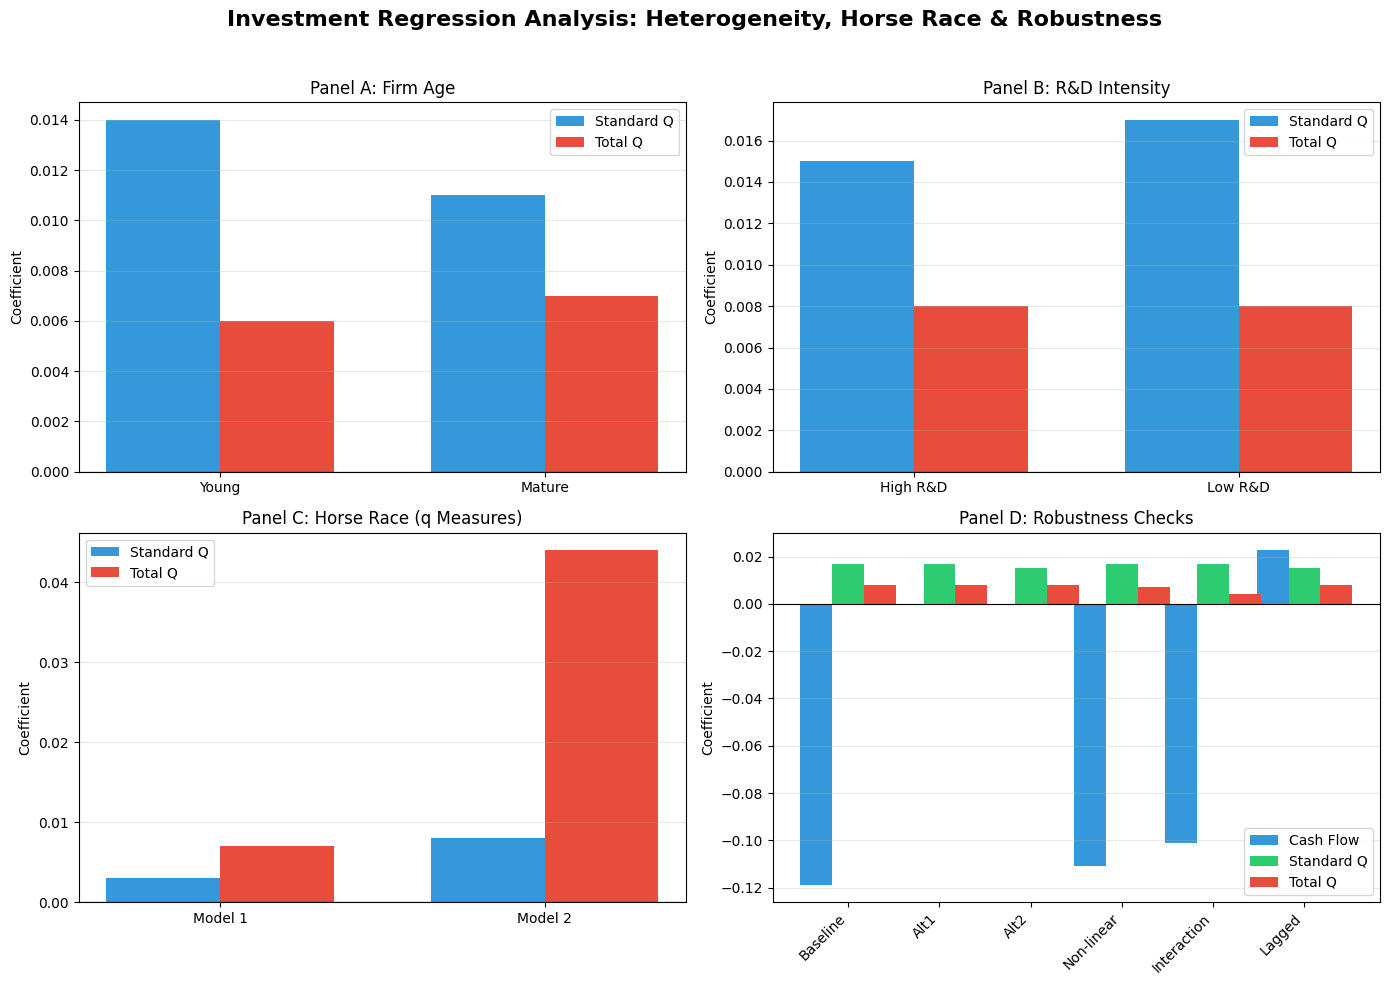

In [87]:
#51 Prepare data for grouped bar chart 
labels_age = ['Young', 'Mature']
coef_age_std = [0.014, 0.011]
coef_age_total = [0.006, 0.007]

labels_rd = ['High R&D', 'Low R&D']
coef_rd_std = [0.015, 0.017]
coef_rd_total = [0.008, 0.008]

labels_horse = ['Model 1', 'Model 2']
coef_horse_std = [0.003, 0.008]
coef_horse_total = [0.007, 0.044]

robust_models = ["Baseline", "Alt1", "Alt2", "Non-linear", "Interaction", "Lagged"]
coef_robust_cash = [-0.119, -0.000, 0.000, -0.111, -0.101, 0.023]
coef_robust_std = [0.017, 0.017, 0.015, 0.017, 0.017, 0.015]
coef_robust_total = [0.008, 0.008, 0.008, 0.007, 0.004, 0.008]

bar_width = 0.35

#Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Panel A: Age
x = np.arange(len(labels_age))
ax = axes[0,0]
ax.bar(x - bar_width/2, coef_age_std, width=bar_width, label='Standard Q', color='#3498db')
ax.bar(x + bar_width/2, coef_age_total, width=bar_width, label='Total Q', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(labels_age)
ax.set_title('Panel A: Firm Age')
ax.set_ylabel('Coefficient')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Panel B: R&D
x = np.arange(len(labels_rd))
ax = axes[0,1]
ax.bar(x - bar_width/2, coef_rd_std, width=bar_width, label='Standard Q', color='#3498db')
ax.bar(x + bar_width/2, coef_rd_total, width=bar_width, label='Total Q', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(labels_rd)
ax.set_title('Panel B: R&D Intensity')
ax.set_ylabel('Coefficient')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Panel C: Horse Race
x = np.arange(len(labels_horse))
ax = axes[1,0]
ax.bar(x - bar_width/2, coef_horse_std, width=bar_width, label='Standard Q', color='#3498db')
ax.bar(x + bar_width/2, coef_horse_total, width=bar_width, label='Total Q', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(labels_horse)
ax.set_title('Panel C: Horse Race (q Measures)')
ax.set_ylabel('Coefficient')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Panel D: Robustness Checks
x = np.arange(len(robust_models))
ax = axes[1,1]
ax.bar(x - bar_width, coef_robust_cash, width=bar_width, label='Cash Flow', color='#3498db')
ax.bar(x, coef_robust_std, width=bar_width, label='Standard Q', color='#2ecc71')
ax.bar(x + bar_width, coef_robust_total, width=bar_width, label='Total Q', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(robust_models, rotation=45, ha='right')
ax.set_title('Panel D: Robustness Checks')
ax.set_ylabel('Coefficient')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Investment Regression Analysis: Heterogeneity, Horse Race & Robustness', fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In conclusion:
In this project, i examine whether incorporating internally generated intangible capital into Tobin’s q restores a stable
relationship between firm valuation and physical investment for U.S. public technology firms since 1995. Using firm
and year-fixed effects panel regressions, subperiod analysis, heterogeneity splits, and extensive robustness checks, i
find a strong evidence that replacing standard q (Tobin’s q) with the Peters-Taylor’s Total q substantially improves
both the stability and the explanatory power of the investment-q relationship.
Firstly, Total q consistently yields higher within-firm R² and slightly larger standardized investment responses than
Standard q. This tells us that, Total q better captures time-varying investment opportunities faced by the same firm
over time, which is the core object of interest in q-theory. On the flip side, Standard q explains less of the within-firm
variation, and its slope declines sharply after 2008, suggesting a breakdown of the classic investment-q relation in
the modern period when intangibles dominate firm value.
Secondly, the subperiod analysis demonstrates that while the sensitivity of investment to Standard q falls by roughly
half after 2008 and its within-firm explanatory power declines substantially, the Total-q slope remains more stable
across both the pre- and post-2000 splits, and its within-firm fit deteriorates much less. This provides direct evidence
that incorporating intangible capital into q stabilizes the investment-q relationship across changing macroeconomic
and technological regimes.
Third, heterogeneity analyses reveal that Total q outperforms Standard q, particularly for young firms and
R&D-intensive firms, where intangible capital is most crucial. In these subsamples, Total q delivers both higher slopesand higher within-firm R², reinforcing the interpretation that Total q is a more accurate proxy for marginal investment
opportunities in intangible-intensive environments.
Finally, robustness checks indicate that the negative Cash-flow coefficient commonly observed in investment
regressions reflects a substitution between intangible and tangible investment when intangible capital is omitted
from the q equation. Under Standard q, cash flow partly proxies for intangible accumulation, producing a misleading
negative relationship with physical investment. Once Total q absorbs intangible capital into the valuation measure,
the negative cash-flow effect weakens. Taken together, these results imply that the apparent failure of q-theory in the
modern economy is largely a measurement problem rather than a failure of the theory itself. When internally
generated intangible capital is properly incorporated into firm valuation, the investment-q relationship remains strong,
stable, and economically meaningful for U.S. tech firms. Total q therefore provides a more reliable measure of
investment opportunities and restores the empirical relevance of q-theory in intangible-intensive sectors.

    Reference:
https://libguides.princeton.edu/R-Panel

Tidy Fixed Effects Regressions: fixest vs pyfixest – Tidy Intelligence

Mixed Effect Regression

https://www.pythonfordatascience.org/mixed-effects-regression-python/

https://py-econometrics.github.io/pyfixest/quickstart.html#how-to-interpret-the-results

https://nengwang-economics.com/research/papers/Lin_Wang_Wang_Yang_JFE_2018.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0304405X19300613

https://www.stern.nyu.edu/sites/default/files/assets/documents/Wharton-Peters_taylor_Intangible%20capital%20%26%20Q.pdf